In [1]:
# ! cp drive/My\ Drive/CT.zip .
# ! unzip CT.zip
# ! conda activate RJR

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import nibabel as nib
from tqdm.notebook import tqdm
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import pandas as pd
import os
import copy

ngpu = torch.cuda.device_count()
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device, ngpu)

cuda:1 2


In [3]:
def get_prior(model, img):
    with torch.no_grad():
        outputs = model(img)
        outputs = torch.argmax(outputs, dim=1)
    return outputs

In [4]:
class Prior_MSD(Dataset):
    def __init__(self, root, imgdir, labeldir, labeldir_left, labeldir_right, prior_list, device, slices=1, train_ratio = 1):
        model_fn = []
        prior_type = ['comp', 'left', 'right']
        for i in prior_type:
            for x in prior_list:
                if i in x:
                    model_fn.append('../prior_models/best_model/' + x)

        self.slices = slices
        assert self.slices % 2 == 1, "slices must be odd!"

        es = int(self.slices/2) # floor operation

        img_fn = [f for f in sorted(os.listdir(root+imgdir)) if f.endswith('.npy')]
        seg_fn = [f for f in sorted(os.listdir(root+labeldir)) if f.endswith('.npy')]
        seg_left = [f for f in sorted(os.listdir(root+labeldir_left)) if f.endswith('.npy')]
        seg_right = [f for f in sorted(os.listdir(root+labeldir_right)) if f.endswith('.npy')]

        n_classes = []
        for i in prior_type:
            if i == 'comp':
                n_classes.append(3)
            else:
                n_classes.append(2)
        
        models = []

        for i in range(len(model_fn)):
            prior_model = UNet2D(n_classes[i], 1).cuda()
            prior_model.load_state_dict(torch.load(model_fn[i]))
            models.append(prior_model)

        self.datalist = []
        
        for i, (img_file, seg_file, seg_left_file, seg_right_file) in enumerate(zip(img_fn, seg_fn, seg_left, seg_right)):

            filename_img = os.path.join(root, imgdir, img_file)
            filename_seg_full = os.path.join(root, labeldir, seg_file)
            filename_seg_left = os.path.join(root, labeldir_left, seg_left_file)
            filename_seg_right = os.path.join(root, labeldir_right, seg_right_file)

            assert img_file.replace('.','_').split('_')[1] == seg_file.replace('.','_').split('_')[1], "Image and label files not from the same patient"
            assert img_file.replace('.','_').split('_')[1] == seg_left_file.replace('.','_').split('_')[1], "Image and label files not from the same patient"
            assert img_file.replace('.','_').split('_')[1] == seg_right_file.replace('.','_').split('_')[1], "Image and label files not from the same patient"
            
            seg_img_data = np.load(filename_seg_full)
            seg_left = np.load(filename_seg_left)
            seg_right = np.load(filename_seg_right)
            img_data = np.load(filename_img)

            output = np.unique(seg_img_data, return_counts=True)
            counts = output[1]
            if i==0:
                weights = counts
            else:
                weights += counts


            assert img_data.shape == seg_img_data.shape, "Image and Labels have different shapes"
            assert img_data.shape == seg_left.shape, "Image and Labels have different shapes"
            assert img_data.shape == seg_right.shape, "Image and Labels have different shapes"
            
            for j in range(img_data.shape[2]):
                image2d = torch.from_numpy(img_data[:,:,j]).unsqueeze(dim=0).type(torch.FloatTensor)
                label2d = torch.from_numpy(seg_img_data[:,:,j]).unsqueeze(dim=0).type(torch.LongTensor)
                label_left = torch.from_numpy(seg_left[:,:,j]).unsqueeze(dim=0).type(torch.LongTensor)
                label_right = torch.from_numpy(seg_right[:,:,j]).unsqueeze(dim=0).type(torch.LongTensor)
                
                input_img = Variable(image2d).unsqueeze(dim=1).cuda()
                output_full = get_prior(models[0], input_img).type(torch.FloatTensor)
                output_left = get_prior(models[1], input_img).type(torch.FloatTensor)
                output_right = get_prior(models[2], input_img).type(torch.FloatTensor)
                cat_full = torch.cat((image2d, output_full), axis=0)
                cat_left = torch.cat((image2d, output_left), axis=0)
                cat_right = torch.cat((image2d, output_right), axis=0)

                if (len(torch.unique(label2d))>=2):
                        self.datalist.append([ cat_full, cat_left, cat_right, image2d , label2d , label_left, label_right])
        self.weights = torch.Tensor(weights)
        self.weights = torch.sum(self.weights) - self.weights
        self.weights = self.weights / torch.sum(self.weights)

    def __getitem__(self, index):
        [ cat_full, cat_left, cat_right, img, seg, seg_left, seg_right] = self.datalist[index]
        seg_full = copy.deepcopy(seg)
        seg_full[seg_full==2]=1
        cat_hip = copy.deepcopy(cat_full)
        cat_hip[cat_hip==2]=1
        return {'cat_hip' : cat_hip, 'cat_full' : cat_full, 'cat_left' : cat_left, 'cat_right' : cat_right, \
            'img' : img, 'seg' : seg, 'seg_left' : seg_left, 'seg_right' : seg_right, 'seg_full' : seg_full}

    def __len__(self):
        return len(self.datalist)



class Mean_Prior_MSD(Dataset):
    def __init__(self, root, imgdir, labeldir, labeldir_left, labeldir_right, prior_list, device, slices=1, train_ratio = 1):
        model_fn = []
        prior_type = ['comp', 'left', 'right']
        for i in prior_type:
            for x in prior_list:
                if i in x:
                    model_fn.append('../prior_models/best_model/' + x)

        self.slices = slices
        assert self.slices % 2 == 1, "slices must be odd!"

        es = int(self.slices/2) # floor operation

        img_fn = [f for f in sorted(os.listdir(root+imgdir)) if f.endswith('.npy')]
        seg_fn = [f for f in sorted(os.listdir(root+labeldir)) if f.endswith('.npy')]
        seg_left = [f for f in sorted(os.listdir(root+labeldir_left)) if f.endswith('.npy')]
        seg_right = [f for f in sorted(os.listdir(root+labeldir_right)) if f.endswith('.npy')]

        n_classes = []
        for i in prior_type:
            if i == 'comp':
                n_classes.append(3)
            else:
                n_classes.append(2)
        
        prior = np.load('../mean_priors/meanSP.npy')
        
        prior_left = copy.deepcopy(prior)
        prior_right = copy.deepcopy(prior)
        prior_full = copy.deepcopy(prior)
        prior_left[prior_left==2] = 0
        prior = torch.from_numpy(prior).unsqueeze(dim=0).type(torch.FloatTensor)
        prior_left = torch.from_numpy(prior_left).unsqueeze(dim=0).type(torch.FloatTensor)
        
        prior_right[prior_right==1] = 0
        prior_right[prior_right==2] = 1
        prior_right = torch.from_numpy(prior_right).unsqueeze(dim=0).type(torch.FloatTensor)
        
        prior_full[prior_full==2] = 1
        prior_full = torch.from_numpy(prior_full).unsqueeze(dim=0).type(torch.FloatTensor)

        self.datalist = []
        
        for i, (img_file, seg_file, seg_left_file, seg_right_file) in enumerate(zip(img_fn, seg_fn, seg_left, seg_right)):

            filename_img = os.path.join(root, imgdir, img_file)
            filename_seg_full = os.path.join(root, labeldir, seg_file)
            filename_seg_left = os.path.join(root, labeldir_left, seg_left_file)
            filename_seg_right = os.path.join(root, labeldir_right, seg_right_file)

            assert img_file.replace('.','_').split('_')[1] == seg_file.replace('.','_').split('_')[1], "Image and label files not from the same patient"
            assert img_file.replace('.','_').split('_')[1] == seg_left_file.replace('.','_').split('_')[1], "Image and label files not from the same patient"
            assert img_file.replace('.','_').split('_')[1] == seg_right_file.replace('.','_').split('_')[1], "Image and label files not from the same patient"
            
            seg_img_data = np.load(filename_seg_full)
            seg_left = np.load(filename_seg_left)
            seg_right = np.load(filename_seg_right)
            img_data = np.load(filename_img)

            output = np.unique(seg_img_data, return_counts=True)
            counts = output[1]
            if i==0:
                weights = counts
            else:
                weights += counts


            assert img_data.shape == seg_img_data.shape, "Image and Labels have different shapes"
            assert img_data.shape == seg_left.shape, "Image and Labels have different shapes"
            assert img_data.shape == seg_right.shape, "Image and Labels have different shapes"
            
            for j in range(img_data.shape[2]):
                image2d = torch.from_numpy(img_data[:,:,j]).unsqueeze(dim=0).type(torch.FloatTensor)
                label2d = torch.from_numpy(seg_img_data[:,:,j]).unsqueeze(dim=0).type(torch.LongTensor)
                label_left = torch.from_numpy(seg_left[:,:,j]).unsqueeze(dim=0).type(torch.LongTensor)
                label_right = torch.from_numpy(seg_right[:,:,j]).unsqueeze(dim=0).type(torch.LongTensor)
                
                cat_full = torch.cat((image2d, prior), axis=0)
                cat_left = torch.cat((image2d, prior_left), axis=0)
                cat_right = torch.cat((image2d, prior_right), axis=0)

                if (len(torch.unique(label2d))>=2):
                        self.datalist.append([ cat_full, cat_left, cat_right, image2d , label2d , label_left, label_right])
        self.weights = torch.Tensor(weights)
        self.weights = torch.sum(self.weights) - self.weights
        self.weights = self.weights / torch.sum(self.weights)

    def __getitem__(self, index):
        [ cat_full, cat_left, cat_right, img, seg, seg_left, seg_right] = self.datalist[index]
        seg_full = copy.deepcopy(seg)
        seg_full[seg_full==2]=1
        cat_hip = copy.deepcopy(cat_full)
        cat_hip[cat_hip==2]=1
        return {'cat_hip' : cat_hip, 'cat_full' : cat_full, 'cat_left' : cat_left, 'cat_right' : cat_right, \
            'img' : img, 'seg' : seg, 'seg_left' : seg_left, 'seg_right' : seg_right, 'seg_full' : seg_full}

    def __len__(self):
        return len(self.datalist)

In [5]:
def get_train_val_loader(dataset_obj, validation_split, batch_size = 1, train_ratio = 1.0, n_cpus = 4,\
    numpy_seed = 0, torch_seed = 0, shuffle_dataset=True):
    

    dataset_size = len(dataset_obj)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(numpy_seed)
        torch.manual_seed(torch_seed)
    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices[0:int(train_ratio*len(train_indices))])
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset_obj, batch_size=batch_size, 
                                            sampler=train_sampler, num_workers=n_cpus)
    validation_loader = DataLoader(dataset_obj, batch_size=batch_size,
                                                sampler=valid_sampler, num_workers=n_cpus)
    return train_loader, validation_loader, dataset_obj.weights

In [6]:
def eval_subnet_right(model_full, model_left, num_classes, validation_loader, input_type, output_type_left, output_type_right, output_type_full, wandb):

    val_losses = []
    val_dscoeffs = []
    val_avg_losses = []
    val_avg_dscoeffs = []

    val_avg_loss = 0.0
    val_avg_dscoeff = 0.0

    
    pbar_val = tqdm(total = len(validation_loader), desc = "Val: Avg loss{}, avg_dice{}"\
            .format(val_avg_loss,val_avg_dscoeff), leave=False)
    pbar_val.n = 0
    
    count = 0
    val_dscoeffs = []
    for i, batch in enumerate(validation_loader):
        with torch.no_grad():
            count+=1
            input_img = Variable(batch[input_type]).cuda()
            segs_left = Variable(batch[output_type_left]).cuda()
            segs_right = Variable(batch[output_type_right]).cuda()
            segs_full = Variable(batch[output_type_full]).cuda()

            output_full = model_full(input_img)
            output_left = model_left(input_img)

            dscoeff_full, outs_full, segs_full = dice_coeff_multiclass(segs_full, output_full, num_classes)
            dscoeff_left, outs_left, segs_left = dice_coeff_multiclass(segs_left, output_left, num_classes)
            output_right = outs_full - outs_left
            output_right[output_right<0] = 0
            dscoeff_right, outs_right, segs_right = dice_coeff_multiclass(segs_right, output_right, 2, subnet = True)
            
            val_dscoeffs.append(dscoeff_right[-1])

            pbar_val.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format\
                (val_avg_loss/count,val_avg_dscoeff/count))
            pbar_val.update(1)
            
    pbar_val.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".\
        format(val_avg_loss/len(validation_loader),val_avg_dscoeff/len(validation_loader)))
    table = wandb.Table(columns=["Posterior SubNet"])
    table.add_data(str(np.mean(np.array(val_dscoeffs))))
    wandb.log({"Posterior Subnet": table})

    return np.mean(np.array(val_dscoeffs))

In [7]:
class MyConvTranspose2d(nn.Module):
    def __init__(self, conv):
        super(MyConvTranspose2d, self).__init__()
        self.conv = conv
        
    def forward(self, x, output_size):
        x = self.conv(x, output_size=output_size)
        return x
    
class conv_block(nn.Module):
    def __init__(self, num_channels, num_filters):
        super(conv_block, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, num_filters, (3, 3), padding=1)
        self.conv1_bn = nn.BatchNorm2d(num_filters)
        self.conv2 = nn.Conv2d(num_filters, num_filters, (3, 3), padding=1)
        self.conv2_bn = nn.BatchNorm2d(num_filters) 
    
    def forward(self, inp_tensor):
        encoder = self.conv1(inp_tensor)
        encoder = self.conv1_bn(encoder)
        encoder = torch.relu(encoder)
        encoder = self.conv2(encoder)
        encoder = self.conv2_bn(encoder)
        encoder = torch.relu(encoder)
        return encoder

class encoder_block(nn.Module):
    def __init__(self, num_channels, num_filters):
        super(encoder_block, self).__init__()
        self.conv_block1 = conv_block(num_channels, num_filters)
        self.max_pool1 = nn.MaxPool2d((2, 2), (2, 2))
    
    def forward(self, inp_tensor):
        encoder = self.conv_block1(inp_tensor)
        encoder_pool = self.max_pool1(encoder)
        return (encoder_pool, encoder)

class decoder_block(nn.Module):
    def __init__(self, num_channels, num_filters):
        super(decoder_block, self).__init__()
        conv = nn.ConvTranspose2d(num_channels, num_filters, (2, 2), stride=(2, 2))
        self.conv_tp1 = MyConvTranspose2d(conv)
        self.conv_tp1_bn = nn.BatchNorm2d(2*num_filters)
        self.conv_tp2 = nn.Conv2d(2*num_filters, num_filters, (3, 3), padding=1)
        self.conv_tp2_bn = nn.BatchNorm2d(num_filters)
        self.conv_tp3 = nn.Conv2d(num_filters, num_filters, (3, 3), padding=1)
        self.conv_tp3_bn = nn.BatchNorm2d(num_filters)

    def forward(self, inp_tensor, concat_tensor, output_size):
        decoder = self.conv_tp1(inp_tensor,output_size=output_size)
        decoder = torch.cat((concat_tensor, decoder), 1)
        decoder = self.conv_tp1_bn(decoder)
        decoder = torch.relu(decoder)
        decoder = self.conv_tp2(decoder)
        decoder = self.conv_tp2_bn(decoder)
        decoder = torch.relu(decoder)
        decoder = self.conv_tp3(decoder)
        decoder = self.conv_tp3_bn(decoder)
        decoder = torch.relu(decoder)
        return decoder

In [8]:
class UNet2D(nn.Module):
    def __init__(self, num_classes, num_channels=3):
        super(UNet2D, self).__init__()
        self.encoder_block0 = encoder_block(num_channels, 32)
        self.encoder_block1 = encoder_block(32, 64)
        self.encoder_block2 = encoder_block(64, 128)
        self.encoder_block3 = encoder_block(128, 256)
#         self.encoder_block4 = encoder_block(256, 512)
        self.center = conv_block(256, 512)
#         self.decoder_block4 = decoder_block(1024, 512)
        self.decoder_block3 = decoder_block(512, 256)
        self.decoder_block2 = decoder_block(256, 128)
        self.decoder_block1 = decoder_block(128, 64)
        self.decoder_block0 = decoder_block(64, 32)
        self.conv_final = nn.Conv2d(32, num_classes, (1, 1))
    
    def forward(self, inputs):
        # inputs = x # 256

        encoder0_pool, encoder0 = self.encoder_block0(inputs) # 128
        encoder1_pool, encoder1 = self.encoder_block1(encoder0_pool) # 64
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool) # 32
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool) # 16
#         encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool) # 8

        center = self.center(encoder3_pool) # center (8)

#         decoder4 = self.decoder_block4(center, encoder4) # 16
        
        decoder3 = self.decoder_block3(center, encoder3, output_size=encoder3.shape) # 32
        decoder2 = self.decoder_block2(decoder3, encoder2, output_size=encoder2.shape) # 64
        decoder1 = self.decoder_block1(decoder2, encoder1, output_size=encoder1.shape) # 128
        decoder0 = self.decoder_block0(decoder1, encoder0, output_size=encoder0.shape) # 256

        outputs = torch.sigmoid(self.conv_final(decoder0))
        return outputs

In [9]:
class MO_Net_encoder(nn.Module):
    def __init__(self, num_channels=3):
        super(MO_Net_encoder, self).__init__()
        self.encoder_block0 = encoder_block(num_channels, 32)
        self.encoder_block1 = encoder_block(32, 64)
        self.encoder_block2 = encoder_block(64, 128)
        self.encoder_block3 = encoder_block(128, 256)
        # self.encoder_block4 = encoder_block(256, 512)
        self.center = conv_block(256, 512)
        
    def forward(self, inputs):
        # inputs = x # 256

        encoder0_pool, encoder0 = self.encoder_block0(inputs) # 128
        encoder1_pool, encoder1 = self.encoder_block1(encoder0_pool) # 64
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool) # 32
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool) # 16
        # encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool) # 8
        center = self.center(encoder3_pool) # center (8)

        return encoder0, encoder1, encoder2, encoder3, center


class MO_Net_decoder(nn.Module):
    def __init__(self, num_classes):
        super(MO_Net_decoder, self).__init__()
        # self.decoder_block4 = decoder_block(1024, 512)
        self.decoder_block3 = decoder_block(512, 256)
        self.decoder_block2 = decoder_block(256, 128)
        self.decoder_block1 = decoder_block(128, 64)
        self.decoder_block0 = decoder_block(64, 32)
        self.conv_final = nn.Conv2d(32, num_classes, (1, 1))
            
    def forward(self, encoder0, encoder1, encoder2, encoder3, center):
        # center = x # (8)

        # decoder4 = self.decoder_block4(center, encoder3) # 16
        decoder3 = self.decoder_block3(center, encoder3, output_size=encoder3.shape) # 32
        decoder2 = self.decoder_block2(decoder3, encoder2, output_size=encoder2.shape) # 64
        decoder1 = self.decoder_block1(decoder2, encoder1, output_size=encoder1.shape) # 128
        decoder0 = self.decoder_block0(decoder1, encoder0, output_size=encoder0.shape) # 256

        outputs = torch.sigmoid(self.conv_final(decoder0))
        return outputs

In [10]:
# lst = os.listdir('../prior_models/best_model/')
# model_name = '../prior_models/best_model/' + lst[0]
# prior_model = UNet2D(2, 1).to(device)
# prior_model.load_state_dict(torch.load(model_name))

In [80]:
root_dir = '../data/Task04_Hippocampus_processed/train/'
imgdir = 'imagesTr'
labeldir = 'labelsTr'
labeldir_left = 'labels_left'
labeldir_right = 'labels_right'
prior_list = os.listdir('../prior_models/best_model/')

input_type = 'img'
output_type = 'seg'

validation_split = 0.2
shuffle_dataset = True
batch_size = 4
random_seed= 42
train_ratio = 1

dataset = Mean_Prior_MSD(root = root_dir, imgdir = imgdir, labeldir = labeldir, labeldir_left = labeldir_left, \
	labeldir_right = labeldir_right, prior_list = prior_list, \
		device = device, train_ratio = train_ratio)
train_loader, validation_loader, weights = get_train_val_loader(dataset_obj = dataset, validation_split = validation_split, \
		batch_size = batch_size, train_ratio = train_ratio, n_cpus = 8)

In [14]:
n_train = len(train_loader)
n_val = len(validation_loader)
a = iter(train_loader)
batch = a.next()
print(len(batch), n_train, n_val)

9 877 219


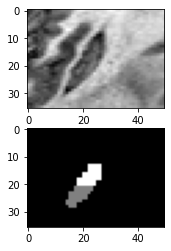

In [25]:
# print(np.unique(dataset[10][2]))
fig = plt.figure()
plt.subplot(2,1,1).imshow(batch['img'][1].squeeze().numpy(), cmap='gray')
plt.subplot(2,1,2).imshow(batch['seg'][1].squeeze().numpy(), cmap='gray')
plt.show()

In [34]:
def dice_coeff(y_true, y_pred):
    smooth = 1
    # print(y_true.shape, y_pred.shape)
    assert y_true.shape == y_pred.shape, "Tensor dimensions must match"
    shape = y_true.shape
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    intersection = torch.sum(y_true_flat * y_pred_flat)
    score = (2. * intersection + smooth) / (torch.sum(y_true_flat) + torch.sum(y_pred_flat) + smooth)
    return score

def dice_coeff_multiclass(y_true, y_pred, num_classes, subnet = False):
    if not subnet:
        dice = []
        output = torch.argmax(y_pred, dim=1).unsqueeze(dim=1)
        for i in range(num_classes):
            segs = y_true.clone().detach()
            segs[y_true==i]=1
            segs[y_true!=i]=0
            # print(torch.unique(segs==y_true))
            outs = output.clone().detach()
            outs[output==i]=1
            outs[output!=i]=0
            # print(torch.unique(outs==output))
            dice.append(dice_coeff(segs, outs).item())
        # print(dice)
        return dice, output, y_true
    else:
        dice = []
        for i in range(num_classes):
            segs = y_true.clone().detach()
            segs[y_true==i]=1
            segs[y_true!=i]=0
            # print(torch.unique(segs==y_true))
            outs = y_pred.clone().detach()
            outs[y_pred==i]=1
            outs[y_pred!=i]=0
            # print(torch.unique(outs==output))
            dice.append(dice_coeff(segs, outs).item())
        # print(dice)
        return dice, y_pred, y_true

def dice_loss(true, logits, eps=1e-7):
    """Computes the Sørensen–Dice loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss.
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model..unsqueeze(0)
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)

def bce_dice_loss(y_true, y_pred):
    loss = F.binary_cross_entropy(y_pred, y_true) + dice_loss(y_true, y_pred)
    return loss

def cross_ent_dice_loss(y_true, y_pred):
    # print(y_true.shape, y_pred.shape)
    loss = nn.CrossEntropyLoss
    # y_pred = torch.argmax(y_pred, 1)
    loss = F.cross_entropy(y_pred.float(), y_true) + dice_loss(y_true, y_pred)
    return loss

In [73]:
def plot_segs(img, seg, unet, mounet, nftnet, subnet):
    fig = plt.figure(figsize=(20,5))
    plt.subplot(1,6,1).imshow(img, cmap='gray')
    plt.subplot(1,6,1).set_title('Input Image', fontsize = 20)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,6,2).imshow(seg, cmap='gray')
    plt.subplot(1,6,2).set_title('Ground Truth Segmentation', fontsize = 20)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,6,3).imshow(unet, cmap='gray')
    plt.subplot(1,6,3).set_title(' U-Net Seg', fontsize = 20)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,6,4).imshow(mounet, cmap='gray')
    plt.subplot(1,6,4).set_title('MOU-Net Seg', fontsize = 18)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,6,5).imshow(nftnet, cmap='gray')
    plt.subplot(1,6,5).set_title('NFTNet Seg', fontsize = 18)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,6,6).imshow(subnet, cmap='gray')
    plt.subplot(1,6,6).set_title('SUBNet Seg', fontsize = 18)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

In [59]:
# Loading models
# Without SP

unet = UNet2D(3, 1).to(device)
unet.load_state_dict(torch.load('../models_noSP_noweights/UNet/UNet_100_4_0.0002_1_1_3_epoch_100.pt', map_location=device))

mounet_enc = MO_Net_encoder(1).to(device)
mounet_dec = MO_Net_decoder(3).to(device)
mounet_enc.load_state_dict(torch.load('../models_noSP_noweights/MOUNet/enc_MOUNet_50_50_4_0.0002_1_1_3_epoch_50.pt', map_location=device))
mounet_dec.load_state_dict(torch.load('../models_noSP_noweights/MOUNet/dec_MOUNet_50_50_4_0.0002_1_1_3_epoch_50.pt', map_location=device))

nftnet = UNet2D(3, 1).to(device)
nftnet.load_state_dict(torch.load('../models_noSP_noweights/NFTNet/NFTNet_50_50_4_0.0002_1_1_3_epoch_50.pt', map_location=device))

subnet_left = UNet2D(2, 1).to(device)
subnet_full = UNet2D(2, 1).to(device)
subnet_full.load_state_dict(torch.load('../models_noSP_noweights/SUBNet/SUBNet_50_50_4_0.0002_1_1_3_full__epoch_50.pt', map_location=device))
subnet_left.load_state_dict(torch.load('../models_noSP_noweights/SUBNet/SUBNet_50_50_4_0.0002_1_1_3_left__epoch_50.pt', map_location=device))


<All keys matched successfully>

In [81]:
a = iter(validation_loader)


In [82]:
batch = a.next()

In [68]:
input_img = Variable(batch['img']).to(device)
unet_output = unet(input_img)
encoder0, encoder1, encoder2, encoder3, center = mounet_enc(input_img)
mounet_output = mounet_dec(encoder0, encoder1, encoder2, encoder3, center)
nftnet_output = nftnet(input_img)
subnet_f_output = subnet_full(input_img)
subnet_l_output = subnet_left(input_img)

seg = Variable(batch['seg']).to(device)
segs_right = Variable(batch['seg_right']).to(device)

dscoeff, unet_output, seg = dice_coeff_multiclass(seg, unet_output, 3)
dscoeff, mounet_output, seg = dice_coeff_multiclass(seg, mounet_output, 3)
dscoeff, nftnet_output, seg = dice_coeff_multiclass(seg, nftnet_output, 3)

dscoeff, subnet_f_output, seg = dice_coeff_multiclass(seg, subnet_f_output, 2)
dscoeff, subnet_l_output, seg = dice_coeff_multiclass(seg, subnet_l_output, 2)

subnet_r_output = subnet_f_output - subnet_l_output
subnet_r_output[subnet_r_output<0] = 0
dscoeff_right, subnet_r_output, segs_right = dice_coeff_multiclass(segs_right, subnet_r_output, 2, subnet = True)
subnet_r_output[subnet_r_output==1] = 2
subnet_output = subnet_r_output + subnet_l_output
# subnet_output[subnet_output>2] = 2


ipykernel_launcher:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
ipykernel_launcher:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
ipykernel_launcher:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured

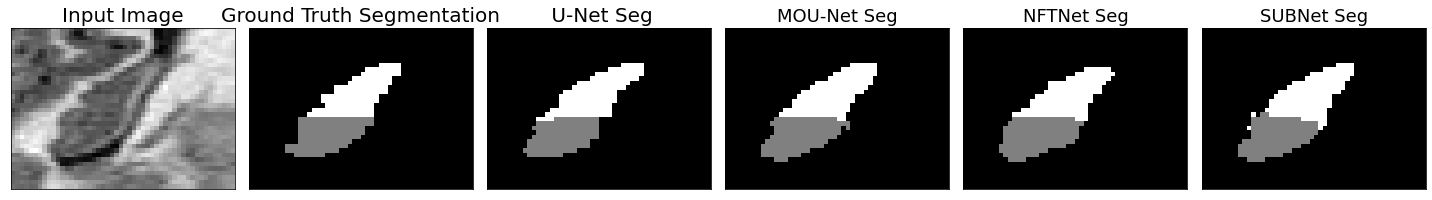

In [74]:
plot_segs(batch['img'][3].squeeze().cpu().numpy(), batch['seg'][3].squeeze().cpu().numpy(), unet_output[3].squeeze().cpu().numpy(), mounet_output[3].squeeze().cpu().numpy(), nftnet_output[3].squeeze().cpu().numpy(), subnet_output[3].squeeze().cpu().numpy())

In [84]:
# Loading models
# With SP

unet = UNet2D(3, 2).to(device)
unet.load_state_dict(torch.load('../models_mean_SP_noweights/UNet/UNet_100_4_0.0002_1_2_3_epoch_100.pt', map_location=device))

mounet_enc = MO_Net_encoder(2).to(device)
mounet_dec = MO_Net_decoder(3).to(device)
mounet_enc.load_state_dict(torch.load('../models_mean_SP_noweights/MOUNet/enc_MOUNet_50_50_4_0.0002_1_2_3_epoch_50.pt', map_location=device))
mounet_dec.load_state_dict(torch.load('../models_mean_SP_noweights/MOUNet/dec_MOUNet_50_50_4_0.0002_1_2_3_epoch_50.pt', map_location=device))

nftnet = UNet2D(3, 2).to(device)
nftnet.load_state_dict(torch.load('../models_mean_SP_noweights/NFTNet/NFTNet_50_50_4_0.0002_1_2_3_epoch_50.pt', map_location=device))

subnet_left = UNet2D(2, 2).to(device)
subnet_full = UNet2D(2, 2).to(device)
subnet_full.load_state_dict(torch.load('../models_mean_SP_noweights/SUBNet/SUBNet_50_50_4_0.0002_1_2_3_full__epoch_50.pt', map_location=device))
subnet_left.load_state_dict(torch.load('../models_mean_SP_noweights/SUBNet/SUBNet_50_50_4_0.0002_1_2_3_left__epoch_50.pt', map_location=device))


<All keys matched successfully>

In [85]:
input_img = Variable(batch['cat_full']).to(device)
unet_output = unet(input_img)
encoder0, encoder1, encoder2, encoder3, center = mounet_enc(input_img)
mounet_output = mounet_dec(encoder0, encoder1, encoder2, encoder3, center)
nftnet_output = nftnet(input_img)
subnet_f_output = subnet_full(input_img)
subnet_l_output = subnet_left(input_img)

seg = Variable(batch['seg']).to(device)
segs_right = Variable(batch['seg_right']).to(device)

dscoeff, unet_output, seg = dice_coeff_multiclass(seg, unet_output, 3)
dscoeff, mounet_output, seg = dice_coeff_multiclass(seg, mounet_output, 3)
dscoeff, nftnet_output, seg = dice_coeff_multiclass(seg, nftnet_output, 3)

dscoeff, subnet_f_output, seg = dice_coeff_multiclass(seg, subnet_f_output, 2)
dscoeff, subnet_l_output, seg = dice_coeff_multiclass(seg, subnet_l_output, 2)

subnet_r_output = subnet_f_output - subnet_l_output
subnet_r_output[subnet_r_output<0] = 0
dscoeff_right, subnet_r_output, segs_right = dice_coeff_multiclass(segs_right, subnet_r_output, 2, subnet = True)
subnet_r_output[subnet_r_output==1] = 2
subnet_output = subnet_r_output + subnet_l_output
# subnet_output[subnet_output>2] = 2


ipykernel_launcher:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
ipykernel_launcher:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
ipykernel_launcher:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured

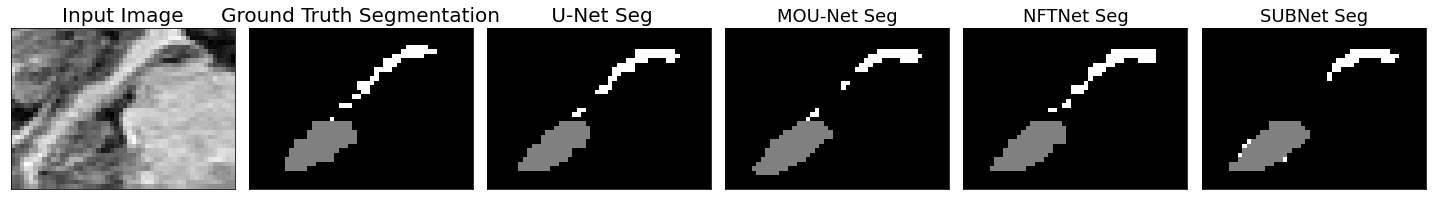

In [88]:
plot_segs(batch['img'][0].squeeze().cpu().numpy(), batch['seg'][0].squeeze().cpu().numpy(), unet_output[0].squeeze().cpu().numpy(), mounet_output[0].squeeze().cpu().numpy(), nftnet_output[0].squeeze().cpu().numpy(), subnet_output[0].squeeze().cpu().numpy())

In [67]:
# Left Class

epochs = 10
batch_size = 1
num_classes = 2
losses1 = []

dscoeffs1 = []
val_losses1 = []
val_dscoeffs1 = []
avg_losses1 = []
val_avg_losses1 = []
avg_dscoeffs1 = []
val_avg_dscoeffs1 = []

model0 = UNet2D(2, 2).to(device)
optimizer = optim.Adam(model0.parameters(), lr = 0.0001)

---------- EPOCH: 1 ----------
----------- TRAINING -------------


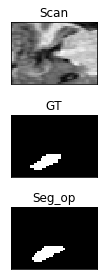

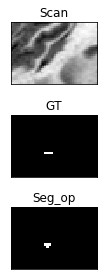

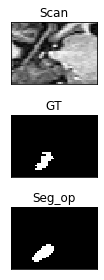

-------------- DONE --------------
---------- VALIDATING ------------


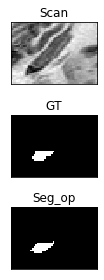

---------- EPOCH: 2 ----------
----------- TRAINING -------------


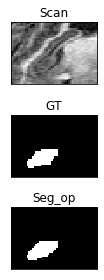

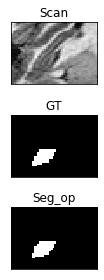

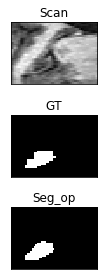

-------------- DONE --------------
---------- VALIDATING ------------


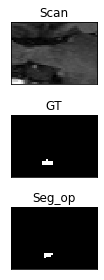

---------- EPOCH: 3 ----------
----------- TRAINING -------------


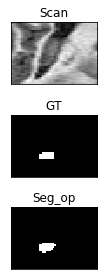

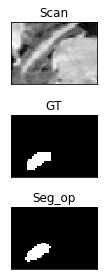

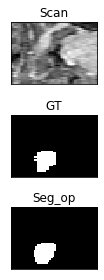

-------------- DONE --------------
---------- VALIDATING ------------


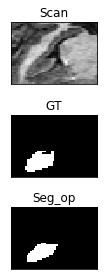

---------- EPOCH: 4 ----------
----------- TRAINING -------------


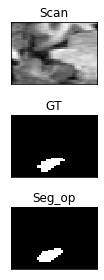

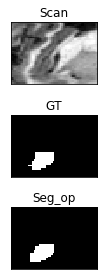

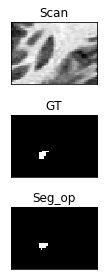

-------------- DONE --------------
---------- VALIDATING ------------


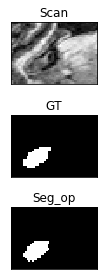

---------- EPOCH: 5 ----------
----------- TRAINING -------------


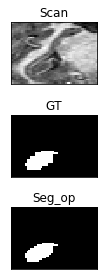

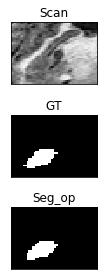

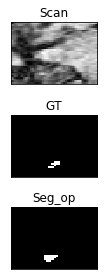

-------------- DONE --------------
---------- VALIDATING ------------


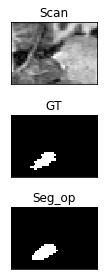

---------- EPOCH: 6 ----------
----------- TRAINING -------------


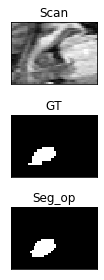

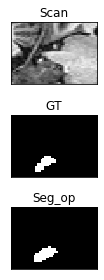

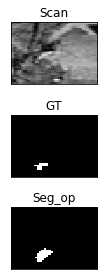

-------------- DONE --------------
---------- VALIDATING ------------


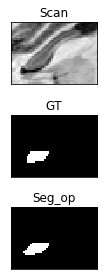

---------- EPOCH: 7 ----------
----------- TRAINING -------------


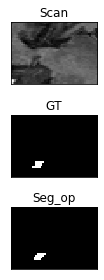

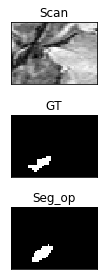

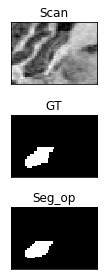

-------------- DONE --------------
---------- VALIDATING ------------


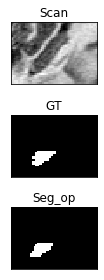

---------- EPOCH: 8 ----------
----------- TRAINING -------------


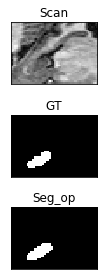

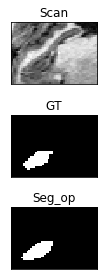

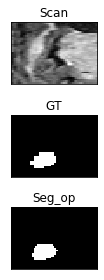

-------------- DONE --------------
---------- VALIDATING ------------


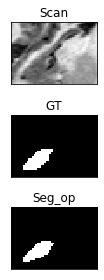

---------- EPOCH: 9 ----------
----------- TRAINING -------------


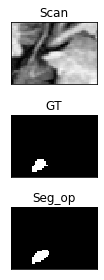

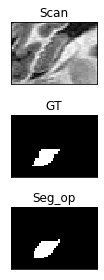

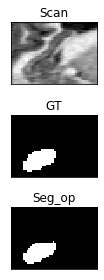

-------------- DONE --------------
---------- VALIDATING ------------


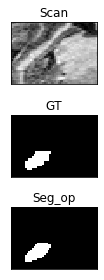

---------- EPOCH: 10 ----------
----------- TRAINING -------------


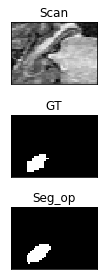

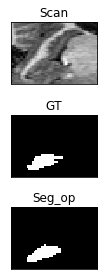

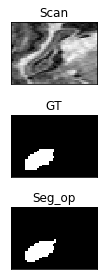

-------------- DONE --------------
---------- VALIDATING ------------


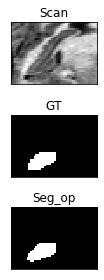

In [100]:
# with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
pbar_outer_outer = tqdm(total=epochs, desc = 'Epoch count')
pbar_outer = tqdm(total=epochs, desc = 'Epoch count')
for epoch in range(1, epochs+1):
    # print('Epoch: ', epoch)
    model0.train()
    avg_loss = 0.0
    avg_dscoeff = 0.0
    print('---------- EPOCH:', epoch, '----------')
    print('----------- TRAINING -------------')
    pbar_inner = tqdm(total = len(train_loader), desc = "train: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
    count = 0
    dscoeffs = []
    for i, batch in enumerate(train_loader):
        count+=1
        optimizer.zero_grad()
#         print(len(batch[0]))
        input_img = Variable(batch[1]).to(device)
        segs = Variable(batch[5][0].unsqueeze(0)).to(device)
        outputs = model0(input_img)
        # print(outputs.shape)
        # print(torch.argmax(outputs, 1).shape)
        
        loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
        loss.backward()
        optimizer.step()
        dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, num_classes)
        dscoeffs.append(dscoeff)
        
        
        if (count%1000==1):
            fig = plt.figure()
            plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,1).set_title('Scan')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3,1,2).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,2).set_title('GT')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3,1,3).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,3).set_title('Seg_op')
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            plt.show()
        # losses1.append(loss.item())
        # dscoeffs.append(dscoeff)
        avg_loss += loss.item()
        avg_dscoeff += sum(dscoeff)/(batch_size*num_classes)
        pbar_inner.set_description("train: Avg lnum_classesoss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/count,avg_dscoeff/count))
        pbar_inner.update(batch_size)
        pbar_outer.set_description("Epoch count: {}".format(epoch))
    # print(np.array(dscoeffs).shape)
    dscoeffs1.append(np.sum(np.array(dscoeffs), axis = 0)/len(train_loader))
    avg_losses1.append(avg_loss/len(train_loader))
    avg_dscoeffs1.append(avg_dscoeff/len(train_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("train: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/len(train_loader),avg_dscoeff/len(train_loader)))
#         pbar.set_postfix(**{'loss (batch)': loss.item(), 'DSC (batch)': dscoeff})
#         pbar.update(i)

    print('-------------- DONE --------------')
    # model0.eval()
    val_avg_loss = 0.0
    val_avg_dscoeff = 0.0
    print('---------- VALIDATING ------------')
    pbar_inner = tqdm(total = len(validation_loader), desc = "Val: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
    count = 0
    val_dscoeffs = []
    for i, batch in enumerate(validation_loader):
        with torch.no_grad():
            count+=1
            # optimizer.zero_grad()
    #         print(len(batch[0]))
            input_img = Variable(batch[1]).to(device)
            segs = Variable(batch[5][0].unsqueeze(0)).to(device)
            outputs = model0(input_img)
            # print(outputs.shape)
            # print(torch.unique(torch.argmax(outputs, 1)))
            
            loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
            # loss.backward()
            # optimizer.step()
            dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, num_classes)
            
            val_dscoeffs.append(dscoeff)
            
            # print(torch.unique(outs))
    #             print("Epoch:", epoch, "| Iter:", i+1, "| loss:", round(loss.item(), 4), "| dsc:", round(dscoeff, 4))
            if (count%1000==1):
                fig = plt.figure()
                plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,1).set_title('Scan')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,2).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,2).set_title('GT')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,3).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,3).set_title('Seg_op')
                plt.xticks([])
                plt.yticks([])
                plt.tight_layout()
                plt.show()
            # val_losses.append(loss.item())
            # val_dscoeffs.append(dscoeff)
            val_avg_loss += loss.item()
            val_avg_dscoeff += sum(dscoeff)/(batch_size*num_classes)
            pbar_inner.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/count,val_avg_dscoeff/count))
            pbar_inner.update(batch_size)
            pbar_outer.set_description("Epoch count: {}".format(epoch))
    val_dscoeffs1.append(np.sum(np.array(val_dscoeffs), axis=0)/len(validation_loader))
    val_avg_dscoeffs1.append(val_avg_dscoeff/len(validation_loader))
    val_avg_losses1.append(val_avg_loss/len(validation_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/len(validation_loader),val_avg_dscoeff/len(validation_loader)))

In [101]:
print(dscoeffs1[-1])
print(val_dscoeffs1[-1])

[0.99613948 0.87896502]
[0.99482669 0.82939493]


In [ ]:
final_avg = np.array(val_avg_dscoeffs)
max_epoch = np.where(final_avg==np.max(final_avg))
max_epoch[0][0]

In [26]:
filepath = 'saved_model_left_'+str(train_ratio)+'_SP.pt'
torch.save(model0.state_dict(), filepath)

In [102]:
# Right Class

epochs = 10
batch_size = 1
num_classes = 2
losses2 = []

dscoeffs2 = []
val_losses2 = []
val_dscoeffs2 = []
avg_losses2 = []
val_avg_losses2 = []
avg_dscoeffs2 = []
val_avg_dscoeffs2 = []

model1 = UNet2D(2, 2).to(device)
optimizer = optim.Adam(model1.parameters(), lr = 0.0001)

---------- EPOCH: 1 ----------
----------- TRAINING -------------


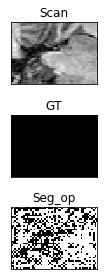

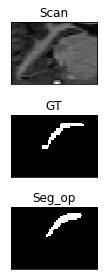

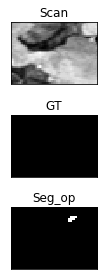

-------------- DONE --------------
---------- VALIDATING ------------


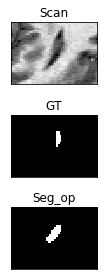

---------- EPOCH: 2 ----------
----------- TRAINING -------------


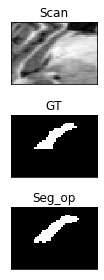

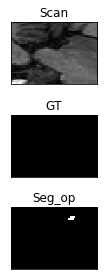

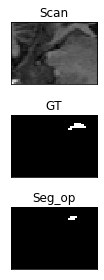

-------------- DONE --------------
---------- VALIDATING ------------


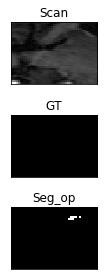

---------- EPOCH: 3 ----------
----------- TRAINING -------------


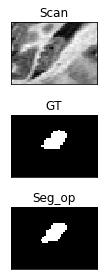

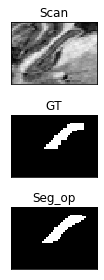

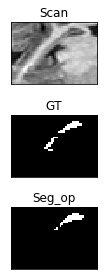

-------------- DONE --------------
---------- VALIDATING ------------


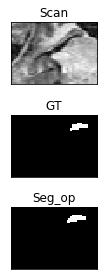

---------- EPOCH: 4 ----------
----------- TRAINING -------------


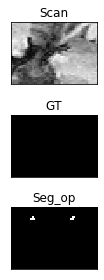

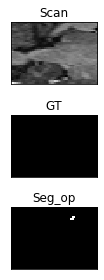

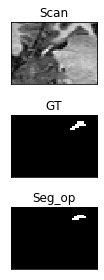

-------------- DONE --------------
---------- VALIDATING ------------


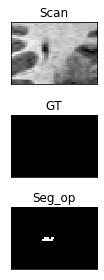

---------- EPOCH: 5 ----------
----------- TRAINING -------------


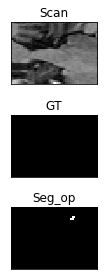

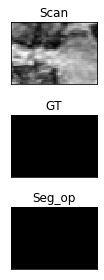

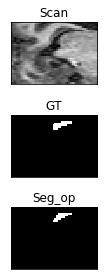

-------------- DONE --------------
---------- VALIDATING ------------


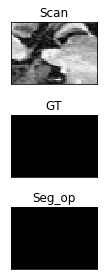

---------- EPOCH: 6 ----------
----------- TRAINING -------------


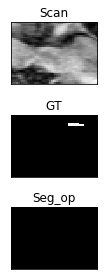

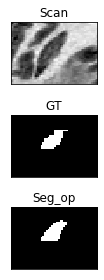

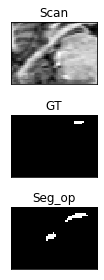

-------------- DONE --------------
---------- VALIDATING ------------


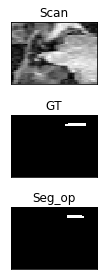

---------- EPOCH: 7 ----------
----------- TRAINING -------------


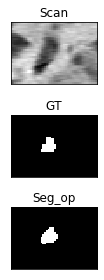

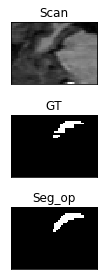

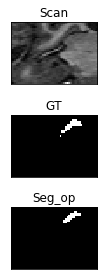

-------------- DONE --------------
---------- VALIDATING ------------


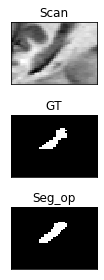

---------- EPOCH: 8 ----------
----------- TRAINING -------------


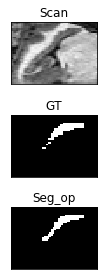

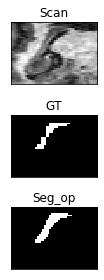

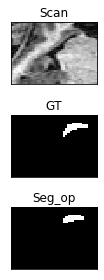

-------------- DONE --------------
---------- VALIDATING ------------


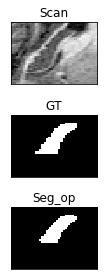

---------- EPOCH: 9 ----------
----------- TRAINING -------------


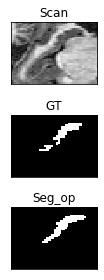

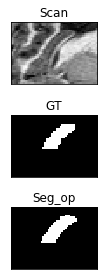

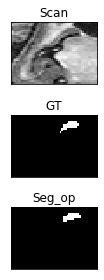

-------------- DONE --------------
---------- VALIDATING ------------


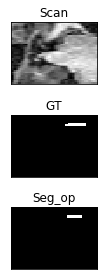

---------- EPOCH: 10 ----------
----------- TRAINING -------------


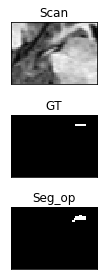

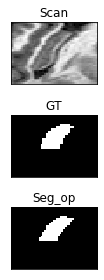

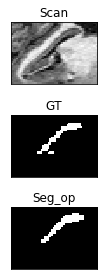

-------------- DONE --------------
---------- VALIDATING ------------


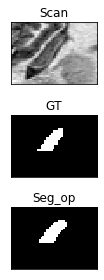

In [103]:
# with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
pbar_outer_outer = tqdm(total=epochs, desc = 'Epoch count')
pbar_outer = tqdm(total=epochs, desc = 'Epoch count')
for epoch in range(1, epochs+1):
    # print('Epoch: ', epoch)
    model1.train()
    avg_loss = 0.0
    avg_dscoeff = 0.0
    print('---------- EPOCH:', epoch, '----------')
    print('----------- TRAINING -------------')
    pbar_inner = tqdm(total = len(train_loader), desc = "train: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
    count = 0
    dscoeffs = []
    for i, batch in enumerate(train_loader):
        count+=1
        optimizer.zero_grad()
#         print(len(batch[0]))
        input_img = Variable(batch[2]).to(device)
        segs = Variable(batch[6][0].unsqueeze(0)).to(device)
        outputs = model1(input_img)
        # print(outputs.shape)
        # print(torch.argmax(outputs, 1).shape)
        
        loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
        loss.backward()
        optimizer.step()
        dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, num_classes)
        dscoeffs.append(dscoeff)
        
        
        if (count%1000==1):
            fig = plt.figure()
            plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,1).set_title('Scan')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3,1,2).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,2).set_title('GT')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3,1,3).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,3).set_title('Seg_op')
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            plt.show()
        # losses1.append(loss.item())
        # dscoeffs.append(dscoeff)
        avg_loss += loss.item()
        avg_dscoeff += sum(dscoeff)/(batch_size*num_classes)
        pbar_inner.set_description("train: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/count,avg_dscoeff/count))
        pbar_inner.update(batch_size)
        pbar_outer.set_description("Epoch count: {}".format(epoch))
    # print(np.array(dscoeffs).shape)
    dscoeffs2.append(np.sum(np.array(dscoeffs), axis = 0)/len(train_loader))
    avg_losses2.append(avg_loss/len(train_loader))
    avg_dscoeffs2.append(avg_dscoeff/len(train_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("train: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/len(train_loader),avg_dscoeff/len(train_loader)))
#         pbar.set_postfix(**{'loss (batch)': loss.item(), 'DSC (batch)': dscoeff})
#         pbar.update(i)

    print('-------------- DONE --------------')
    val_avg_loss = 0.0
    val_avg_dscoeff = 0.0
    print('---------- VALIDATING ------------')
    pbar_inner = tqdm(total = len(validation_loader), desc = "Val: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
    count = 0
    val_dscoeffs = []
    for i, batch in enumerate(validation_loader):
        with torch.no_grad():
            count+=1
            # optimizer.zero_grad()
    #         print(len(batch[0]))
            input_img = Variable(batch[2]).to(device)
            segs = Variable(batch[6][0].unsqueeze(0)).to(device)
            outputs = model1(input_img)
            # print(outputs.shape)
            # print(torch.unique(torch.argmax(outputs, 1)))
            
            loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
            # loss.backward()
            # optimizer.step()
            dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, num_classes)
            
            val_dscoeffs.append(dscoeff)
            
            # print(torch.unique(outs))
    #             print("Epoch:", epoch, "| Iter:", i+1, "| loss:", round(loss.item(), 4), "| dsc:", round(dscoeff, 4))
            if (count%1000==1):
                fig = plt.figure()
                plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,1).set_title('Scan')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,2).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,2).set_title('GT')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,3).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,3).set_title('Seg_op')
                plt.xticks([])
                plt.yticks([])
                plt.tight_layout()
                plt.show()
            # val_losses.append(loss.item())
            # val_dscoeffs.append(dscoeff)
            val_avg_loss += loss.item()
            val_avg_dscoeff += sum(dscoeff)/(batch_size*num_classes)
            pbar_inner.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/count,val_avg_dscoeff/count))
            pbar_inner.update(batch_size)
            pbar_outer.set_description("Epoch count: {}".format(epoch))
    val_dscoeffs2.append(np.sum(np.array(val_dscoeffs), axis=0)/len(validation_loader))
    val_avg_dscoeffs2.append(val_avg_dscoeff/len(validation_loader))
    val_avg_losses2.append(val_avg_loss/len(validation_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/len(validation_loader),val_avg_dscoeff/len(validation_loader)))

In [104]:
print(dscoeffs2[-1])
print(val_dscoeffs2[-1])

[0.99517525 0.83414297]
[0.99387625 0.77317867]


In [25]:
filepath = 'saved_model_right_'+str(train_ratio)+'_SP.pt'
torch.save(model1.state_dict(), filepath)

In [22]:
from torchvision import utils


In [23]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [24]:
train_ratio = 1

In [27]:
model1 = UNet2D(2, 2).to(device)
model1.load_state_dict(torch.load('saved_model_left_'+str(train_ratio)+'_SP.pt', map_location=device))
model0 = UNet2D(2, 2).to(device)
model0.load_state_dict(torch.load('saved_model_right_'+str(train_ratio)+'_SP.pt', map_location=device))

<All keys matched successfully>

In [73]:
params1 = model0.state_dict()
filter_list = []
for item in params1:
    # print(params1[item].type())
    if params1[item].type() == 'torch.cuda.FloatTensor':
        params1[item].requires_grad = True
    if (params1[item].requires_grad == True):
        # print(params1[item].requires_grad)
        filter_list.append(params1[item])

In [29]:
# filter_list

In [30]:
# params1 = model0.state_dict()
# filter_list = []
# for item in params1:
#     if (params1[item].requires_grad==True):
#         filter_list.append(params1[item])
# filter_list

In [31]:
# params2 = model1.state_dict()
# filter_list2 = []
# for item in params2:
#     if (len(params2[item].shape)>3):
#         filter_list2.append(params2[item])

In [105]:
params2 = model1.state_dict()
filter_list2 = []
for item in params2:
    # print(params1[item].type())
    if params2[item].type() == 'torch.cuda.FloatTensor':
        params2[item].requires_grad = True
    if (params2[item].requires_grad == True):
        # print(params1[item].requires_grad)
        filter_list2.append(params2[item])

In [106]:
print(len(filter_list), len(filter_list2))
diff_norm = []
for i in range(len(filter_list)):
    # print(filter_list[i].shape==filter_list2[i].shape)
    new_ten = filter_list[i] - filter_list2[i]
    print(torch.norm(new_ten))
    diff_norm.append(torch.norm(new_ten))

134 134
tensor(5.4728, device='cuda:0', grad_fn=<NormBackward0>)
tensor(1.0903, device='cuda:0', grad_fn=<NormBackward0>)
tensor(0.1689, device='cuda:0', grad_fn=<NormBackward0>)
tensor(0.1609, device='cuda:0', grad_fn=<NormBackward0>)
tensor(90490.6094, device='cuda:0', grad_fn=<NormBackward0>)
tensor(1.3630e+09, device='cuda:0', grad_fn=<NormBackward0>)
tensor(5.1056, device='cuda:0', grad_fn=<NormBackward0>)
tensor(0.2483, device='cuda:0', grad_fn=<NormBackward0>)
tensor(0.1634, device='cuda:0', grad_fn=<NormBackward0>)
tensor(0.1490, device='cuda:0', grad_fn=<NormBackward0>)
tensor(3.8272, device='cuda:0', grad_fn=<NormBackward0>)
tensor(2.3054, device='cuda:0', grad_fn=<NormBackward0>)
tensor(7.1447, device='cuda:0', grad_fn=<NormBackward0>)
tensor(0.3570, device='cuda:0', grad_fn=<NormBackward0>)
tensor(0.1928, device='cuda:0', grad_fn=<NormBackward0>)
tensor(0.1673, device='cuda:0', grad_fn=<NormBackward0>)
tensor(6.4013, device='cuda:0', grad_fn=<NormBackward0>)
tensor(1.3273, 

In [107]:
diff_norm[3].cpu().detach()>11
diff_sum=0
for i in range(len(diff_norm)):
    diff_sum += diff_norm[3].cpu().detach()
print(diff_sum/len(diff_norm)*20)

tensor(3.2183)


In [108]:
count = 0
for item in params1:
    if params1[item].type() == 'torch.cuda.FloatTensor':
        if diff_norm[count].cpu() > 15:
            params1[item].requires_grad = True
        else:
            params1[item].requires_grad = False
        count+=1
    print(item, params1[item].requires_grad)

encoder_block0.conv_block1.conv1.weight False
encoder_block0.conv_block1.conv1.bias False
encoder_block0.conv_block1.conv1_bn.weight False
encoder_block0.conv_block1.conv1_bn.bias False
encoder_block0.conv_block1.conv1_bn.running_mean True
encoder_block0.conv_block1.conv1_bn.running_var True
encoder_block0.conv_block1.conv1_bn.num_batches_tracked False
encoder_block0.conv_block1.conv2.weight False
encoder_block0.conv_block1.conv2.bias False
encoder_block0.conv_block1.conv2_bn.weight False
encoder_block0.conv_block1.conv2_bn.bias False
encoder_block0.conv_block1.conv2_bn.running_mean False
encoder_block0.conv_block1.conv2_bn.running_var False
encoder_block0.conv_block1.conv2_bn.num_batches_tracked False
encoder_block1.conv_block1.conv1.weight False
encoder_block1.conv_block1.conv1.bias False
encoder_block1.conv_block1.conv1_bn.weight False
encoder_block1.conv_block1.conv1_bn.bias False
encoder_block1.conv_block1.conv1_bn.running_mean False
encoder_block1.conv_block1.conv1_bn.running_var

In [109]:
model0.train()
for item in params1:
    print(item, params1[item].requires_grad)

encoder_block0.conv_block1.conv1.weight False
encoder_block0.conv_block1.conv1.bias False
encoder_block0.conv_block1.conv1_bn.weight False
encoder_block0.conv_block1.conv1_bn.bias False
encoder_block0.conv_block1.conv1_bn.running_mean True
encoder_block0.conv_block1.conv1_bn.running_var True
encoder_block0.conv_block1.conv1_bn.num_batches_tracked False
encoder_block0.conv_block1.conv2.weight False
encoder_block0.conv_block1.conv2.bias False
encoder_block0.conv_block1.conv2_bn.weight False
encoder_block0.conv_block1.conv2_bn.bias False
encoder_block0.conv_block1.conv2_bn.running_mean False
encoder_block0.conv_block1.conv2_bn.running_var False
encoder_block0.conv_block1.conv2_bn.num_batches_tracked False
encoder_block1.conv_block1.conv1.weight False
encoder_block1.conv_block1.conv1.bias False
encoder_block1.conv_block1.conv1_bn.weight False
encoder_block1.conv_block1.conv1_bn.bias False
encoder_block1.conv_block1.conv1_bn.running_mean False
encoder_block1.conv_block1.conv1_bn.running_var

In [76]:
print(len(filter_list))
filter = filter_list[14].cpu()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

134


ValueError: not enough values to unpack (expected 4, got 1)

In [110]:
model2 = UNet2D(3, 2).to(device)
params3 = model2.state_dict()

In [111]:
for item in params1:
    if item in params3:
        if (params3[item].shape == params1[item].shape):
            params3[item] = params1[item]
            params3[item].requires_grad = params1[item].requires_grad

In [112]:
model2.train()
for item in params3:
    print(item, params3[item].requires_grad)

encoder_block0.conv_block1.conv1.weight False
encoder_block0.conv_block1.conv1.bias False
encoder_block0.conv_block1.conv1_bn.weight False
encoder_block0.conv_block1.conv1_bn.bias False
encoder_block0.conv_block1.conv1_bn.running_mean True
encoder_block0.conv_block1.conv1_bn.running_var True
encoder_block0.conv_block1.conv1_bn.num_batches_tracked False
encoder_block0.conv_block1.conv2.weight False
encoder_block0.conv_block1.conv2.bias False
encoder_block0.conv_block1.conv2_bn.weight False
encoder_block0.conv_block1.conv2_bn.bias False
encoder_block0.conv_block1.conv2_bn.running_mean False
encoder_block0.conv_block1.conv2_bn.running_var False
encoder_block0.conv_block1.conv2_bn.num_batches_tracked False
encoder_block1.conv_block1.conv1.weight False
encoder_block1.conv_block1.conv1.bias False
encoder_block1.conv_block1.conv1_bn.weight False
encoder_block1.conv_block1.conv1_bn.bias False
encoder_block1.conv_block1.conv1_bn.running_mean False
encoder_block1.conv_block1.conv1_bn.running_var

In [113]:
pytorch_total_params = sum(params3[p].numel() for p in params3 if params3[p].requires_grad)
print(pytorch_total_params)

6853184


In [114]:
# Left Class

epochs = 10
batch_size = 1
num_classes = 3
losses3 = []

dscoeffs3 = []
val_losses3 = []
val_dscoeffs3 = []
avg_losses3 = []
val_avg_losses3 = []
avg_dscoeffs3 = []
val_avg_dscoeffs3 = []

optimizer = optim.Adam(model2.parameters(), lr = 0.0001)

---------- EPOCH: 1 ----------
----------- TRAINING -------------


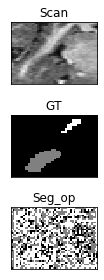

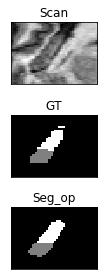

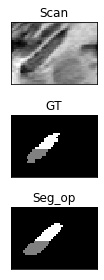

-------------- DONE --------------
---------- VALIDATING ------------


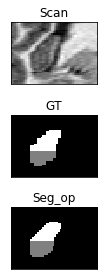

---------- EPOCH: 2 ----------
----------- TRAINING -------------


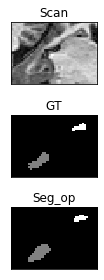

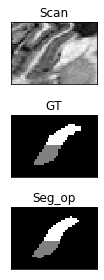

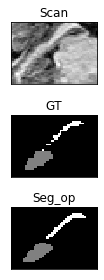

-------------- DONE --------------
---------- VALIDATING ------------


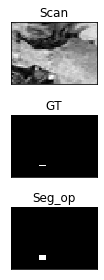

---------- EPOCH: 3 ----------
----------- TRAINING -------------


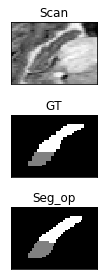

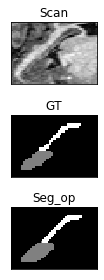

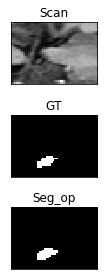

-------------- DONE --------------
---------- VALIDATING ------------


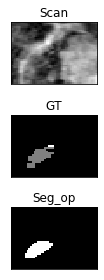

---------- EPOCH: 4 ----------
----------- TRAINING -------------


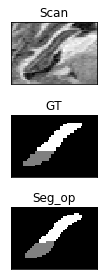

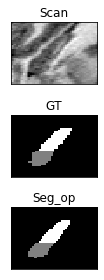

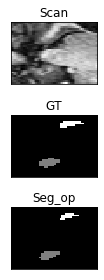

-------------- DONE --------------
---------- VALIDATING ------------


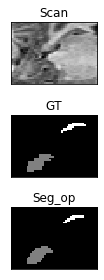

---------- EPOCH: 5 ----------
----------- TRAINING -------------


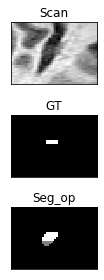

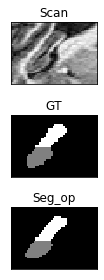

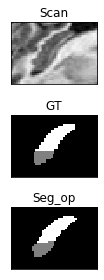

-------------- DONE --------------
---------- VALIDATING ------------


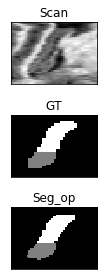

---------- EPOCH: 6 ----------
----------- TRAINING -------------


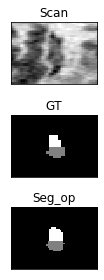

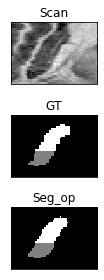

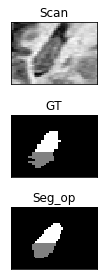

-------------- DONE --------------
---------- VALIDATING ------------


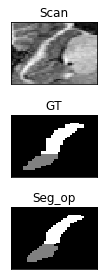

---------- EPOCH: 7 ----------
----------- TRAINING -------------


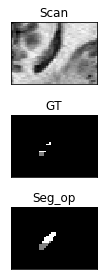

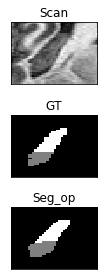

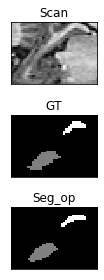

-------------- DONE --------------
---------- VALIDATING ------------


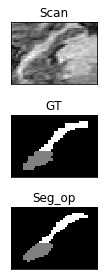

---------- EPOCH: 8 ----------
----------- TRAINING -------------


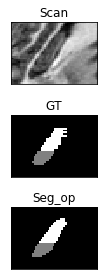

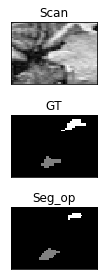

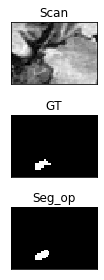

-------------- DONE --------------
---------- VALIDATING ------------


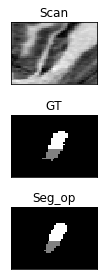

---------- EPOCH: 9 ----------
----------- TRAINING -------------


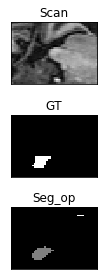

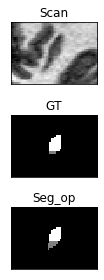

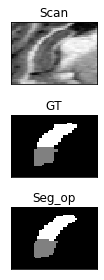

-------------- DONE --------------
---------- VALIDATING ------------


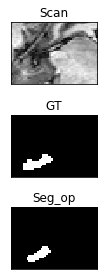

---------- EPOCH: 10 ----------
----------- TRAINING -------------


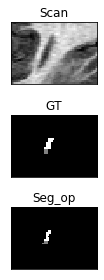

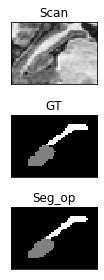

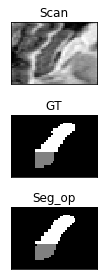

-------------- DONE --------------
---------- VALIDATING ------------


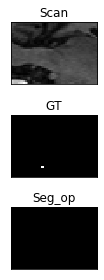

In [115]:
# with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
pbar_outer_outer = tqdm(total=epochs, desc = 'Epoch count')
pbar_outer = tqdm(total=epochs, desc = 'Epoch count')
for epoch in range(1, epochs+1):
    # print('Epoch: ', epoch)
    model2.train()
    avg_loss = 0.0
    avg_dscoeff = 0.0
    print('---------- EPOCH:', epoch, '----------')
    print('----------- TRAINING -------------')
    pbar_inner = tqdm(total = len(train_loader), desc = "train: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
    count = 0
    dscoeffs = []
    for i, batch in enumerate(train_loader):
        count+=1
        optimizer.zero_grad()
#         print(len(batch[0]))
        input_img = Variable(batch[0]).to(device)
        segs = Variable(batch[4][0].unsqueeze(0)).to(device)
        outputs = model2(input_img)
        # print(outputs.shape)
        # print(torch.argmax(outputs, 1).shape)
        
        loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
        loss.backward()
        optimizer.step()
        dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, num_classes)
        dscoeffs.append(dscoeff)
        
        
        if (count%1000==1):
            fig = plt.figure()
            plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,1).set_title('Scan')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3,1,2).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,2).set_title('GT')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3,1,3).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,3).set_title('Seg_op')
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            plt.show()
        # losses1.append(loss.item())
        # dscoeffs.append(dscoeff)
        avg_loss += loss.item()
        avg_dscoeff += sum(dscoeff)/(batch_size*num_classes)
        pbar_inner.set_description("train: Avg lnum_classesoss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/count,avg_dscoeff/count))
        pbar_inner.update(batch_size)
        pbar_outer.set_description("Epoch count: {}".format(epoch))
    # print(np.array(dscoeffs).shape)
    dscoeffs3.append(np.sum(np.array(dscoeffs), axis = 0)/len(train_loader))
    avg_losses3.append(avg_loss/len(train_loader))
    avg_dscoeffs3.append(avg_dscoeff/len(train_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("train: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/len(train_loader),avg_dscoeff/len(train_loader)))
#         pbar.set_postfix(**{'loss (batch)': loss.item(), 'DSC (batch)': dscoeff})
#         pbar.update(i)

    print('-------------- DONE --------------')
    val_avg_loss = 0.0
    val_avg_dscoeff = 0.0
    print('---------- VALIDATING ------------')
    pbar_inner = tqdm(total = len(validation_loader), desc = "Val: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
    count = 0
    val_dscoeffs = []
    for i, batch in enumerate(validation_loader):
        with torch.no_grad():
            count+=1
            # optimizer.zero_grad()
    #         print(len(batch[0]))
            input_img = Variable(batch[0]).to(device)
            segs = Variable(batch[4][0].unsqueeze(0)).to(device)
            outputs = model2(input_img)
            # print(outputs.shape)
            # print(torch.unique(torch.argmax(outputs, 1)))
            
            loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
            # loss.backward()
            # optimizer.step()
            dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, num_classes)
            
            val_dscoeffs.append(dscoeff)
            
            # print(torch.unique(outs))
    #             print("Epoch:", epoch, "| Iter:", i+1, "| loss:", round(loss.item(), 4), "| dsc:", round(dscoeff, 4))
            if (count%1000==1):
                fig = plt.figure()
                plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,1).set_title('Scan')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,2).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,2).set_title('GT')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,3).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,3).set_title('Seg_op')
                plt.xticks([])
                plt.yticks([])
                plt.tight_layout()
                plt.show()
            # val_losses.append(loss.item())
            # val_dscoeffs.append(dscoeff)
            val_avg_loss += loss.item()
            val_avg_dscoeff += sum(dscoeff)/(batch_size*num_classes)
            pbar_inner.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/count,val_avg_dscoeff/count))
            pbar_inner.update(batch_size)
            pbar_outer.set_description("Epoch count: {}".format(epoch))
    val_dscoeffs3.append(np.sum(np.array(val_dscoeffs), axis=0)/len(validation_loader))
    val_avg_dscoeffs3.append(val_avg_dscoeff/len(validation_loader))
    val_avg_losses3.append(val_avg_loss/len(validation_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/len(validation_loader),val_avg_dscoeff/len(validation_loader)))

In [116]:
print(dscoeffs3[-1])
print(val_dscoeffs3[-1])

[0.9923015  0.87807211 0.85425397]
[0.99033724 0.82294774 0.77621859]


In [117]:
print(dscoeffs3[-1])
print(val_dscoeffs3)

[0.9923015  0.87807211 0.85425397]
[array([0.98760906, 0.77391473, 0.72933778]), array([0.98862222, 0.7944573 , 0.74530387]), array([0.98882425, 0.79401746, 0.75276056]), array([0.98936459, 0.80390585, 0.76903017]), array([0.98960172, 0.79980062, 0.76571371]), array([0.98999449, 0.8164127 , 0.76854405]), array([0.98980284, 0.81820322, 0.76711457]), array([0.9897348 , 0.81938744, 0.76086296]), array([0.9903221 , 0.82624187, 0.77028946]), array([0.99033724, 0.82294774, 0.77621859])]


In [45]:
filepath = 'saved_model_UNetNFT'+str(train_ratio)+'_SP.pt'
torch.save(model2.state_dict(), filepath)

In [118]:
# UNet

epochs = 20
batch_size = 1
num_classes = 3
losses1 = []

dscoeffs4 = []
val_losses4 = []
val_dscoeffs4 = []
avg_losses4 = []
val_avg_losses4 = []
avg_dscoeffs4 = []
val_avg_dscoeffs4 = []

model3 = UNet2D(3, 2).to(device)
optimizer = optim.Adam(model3.parameters(), lr = 0.0001)

In [119]:
params4 = model3.state_dict()
for item in params4:
    # print(params1[item].type())
    if params4[item].type() == 'torch.cuda.FloatTensor':
        params4[item].requires_grad = True
    if (params4[item].requires_grad == True):
        print(item, params4[item].requires_grad)
        # filter_list2.append(params2[item])

encoder_block0.conv_block1.conv1.weight True
encoder_block0.conv_block1.conv1.bias True
encoder_block0.conv_block1.conv1_bn.weight True
encoder_block0.conv_block1.conv1_bn.bias True
encoder_block0.conv_block1.conv1_bn.running_mean True
encoder_block0.conv_block1.conv1_bn.running_var True
encoder_block0.conv_block1.conv2.weight True
encoder_block0.conv_block1.conv2.bias True
encoder_block0.conv_block1.conv2_bn.weight True
encoder_block0.conv_block1.conv2_bn.bias True
encoder_block0.conv_block1.conv2_bn.running_mean True
encoder_block0.conv_block1.conv2_bn.running_var True
encoder_block1.conv_block1.conv1.weight True
encoder_block1.conv_block1.conv1.bias True
encoder_block1.conv_block1.conv1_bn.weight True
encoder_block1.conv_block1.conv1_bn.bias True
encoder_block1.conv_block1.conv1_bn.running_mean True
encoder_block1.conv_block1.conv1_bn.running_var True
encoder_block1.conv_block1.conv2.weight True
encoder_block1.conv_block1.conv2.bias True
encoder_block1.conv_block1.conv2_bn.weight Tr

In [120]:
pytorch_total_params = sum(p.numel() for p in model3.parameters() if p.requires_grad)
print(pytorch_total_params)

7767683


---------- EPOCH: 1 ----------
----------- TRAINING -------------


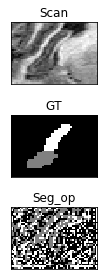

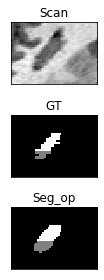

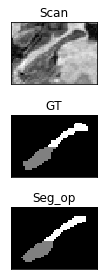

-------------- DONE --------------
---------- VALIDATING ------------


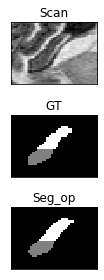

---------- EPOCH: 2 ----------
----------- TRAINING -------------


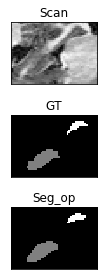

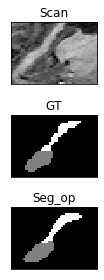

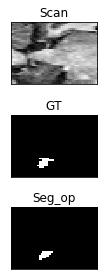

-------------- DONE --------------
---------- VALIDATING ------------


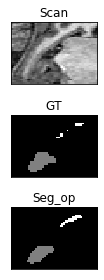

---------- EPOCH: 3 ----------
----------- TRAINING -------------


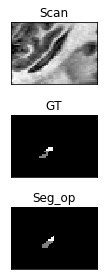

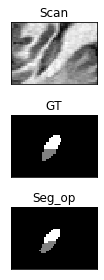

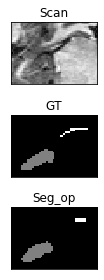

-------------- DONE --------------
---------- VALIDATING ------------


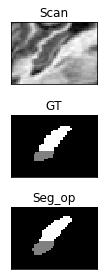

---------- EPOCH: 4 ----------
----------- TRAINING -------------


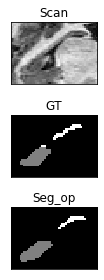

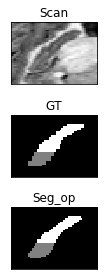

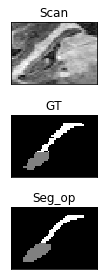

-------------- DONE --------------
---------- VALIDATING ------------


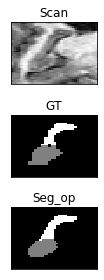

---------- EPOCH: 5 ----------
----------- TRAINING -------------


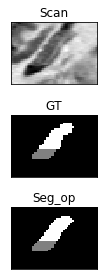

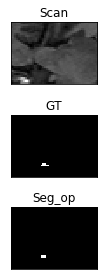

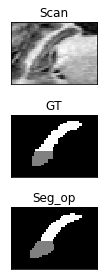

-------------- DONE --------------
---------- VALIDATING ------------


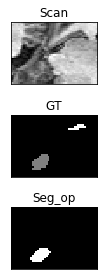

---------- EPOCH: 6 ----------
----------- TRAINING -------------


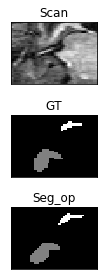

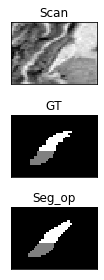

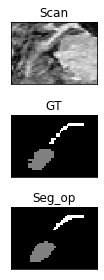

-------------- DONE --------------
---------- VALIDATING ------------


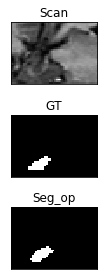

---------- EPOCH: 7 ----------
----------- TRAINING -------------


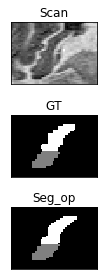

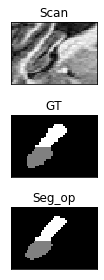

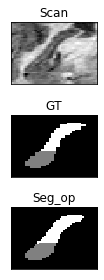

-------------- DONE --------------
---------- VALIDATING ------------


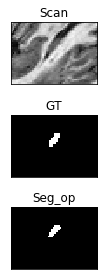

---------- EPOCH: 8 ----------
----------- TRAINING -------------


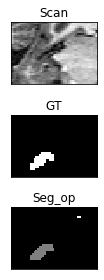

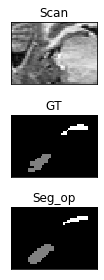

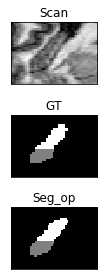

-------------- DONE --------------
---------- VALIDATING ------------


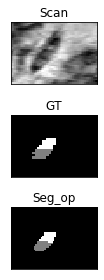

---------- EPOCH: 9 ----------
----------- TRAINING -------------


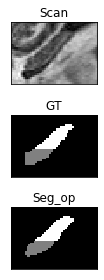

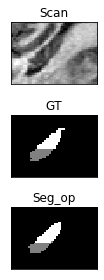

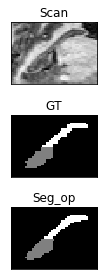

-------------- DONE --------------
---------- VALIDATING ------------


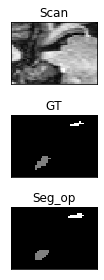

---------- EPOCH: 10 ----------
----------- TRAINING -------------


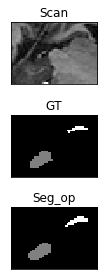

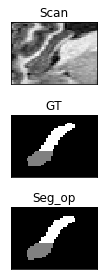

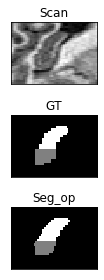

-------------- DONE --------------
---------- VALIDATING ------------


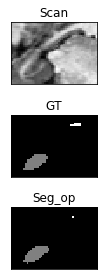

---------- EPOCH: 11 ----------
----------- TRAINING -------------


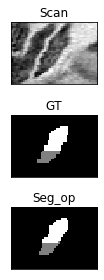

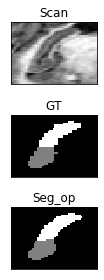

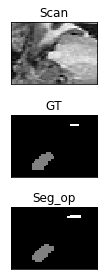

-------------- DONE --------------
---------- VALIDATING ------------


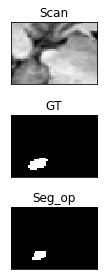

---------- EPOCH: 12 ----------
----------- TRAINING -------------


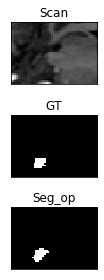

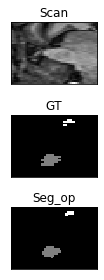

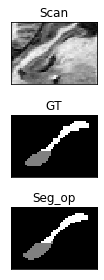

-------------- DONE --------------
---------- VALIDATING ------------


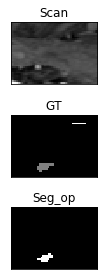

---------- EPOCH: 13 ----------
----------- TRAINING -------------


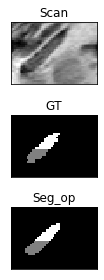

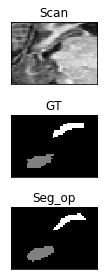

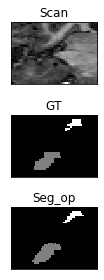

-------------- DONE --------------
---------- VALIDATING ------------


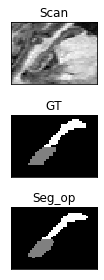

---------- EPOCH: 14 ----------
----------- TRAINING -------------


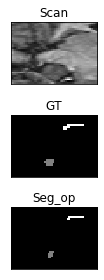

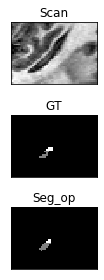

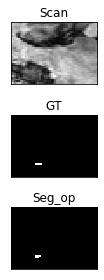

-------------- DONE --------------
---------- VALIDATING ------------


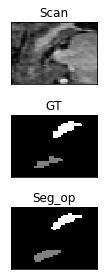

---------- EPOCH: 15 ----------
----------- TRAINING -------------


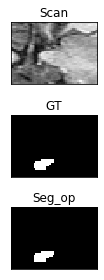

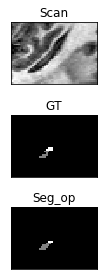

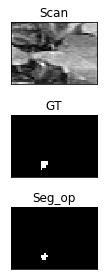

-------------- DONE --------------
---------- VALIDATING ------------


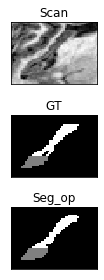

---------- EPOCH: 16 ----------
----------- TRAINING -------------


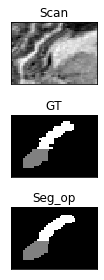

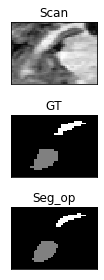

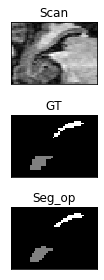

-------------- DONE --------------
---------- VALIDATING ------------


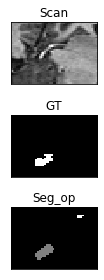

---------- EPOCH: 17 ----------
----------- TRAINING -------------


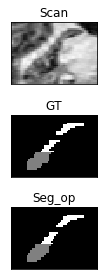

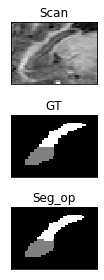

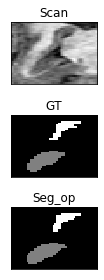

-------------- DONE --------------
---------- VALIDATING ------------


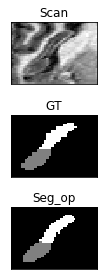

---------- EPOCH: 18 ----------
----------- TRAINING -------------


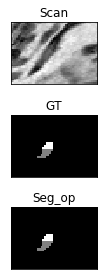

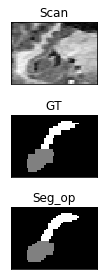

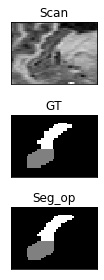

-------------- DONE --------------
---------- VALIDATING ------------


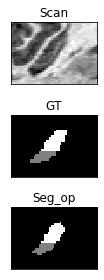

---------- EPOCH: 19 ----------
----------- TRAINING -------------


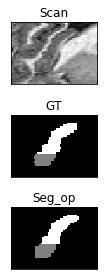

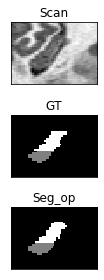

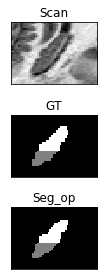

-------------- DONE --------------
---------- VALIDATING ------------


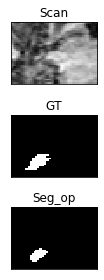

---------- EPOCH: 20 ----------
----------- TRAINING -------------


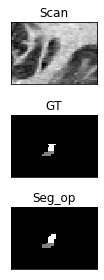

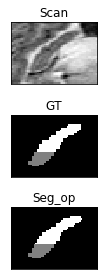

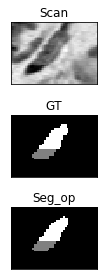

-------------- DONE --------------
---------- VALIDATING ------------


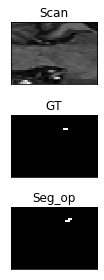

In [121]:
# with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
pbar_outer_outer = tqdm(total=epochs, desc = 'Epoch count')
pbar_outer = tqdm(total=epochs, desc = 'Epoch count')
for epoch in range(1, epochs+1):
    # print('Epoch: ', epoch)
    model3.train()
    avg_loss = 0.0
    avg_dscoeff = 0.0
    print('---------- EPOCH:', epoch, '----------')
    print('----------- TRAINING -------------')
    pbar_inner = tqdm(total = len(train_loader), desc = "train: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
    count = 0
    dscoeffs = []
    for i, batch in enumerate(train_loader):
        count+=1
        optimizer.zero_grad()
#         print(len(batch[0]))
        input_img = Variable(batch[0].type(torch.FloatTensor)).to(device)
        segs = Variable(batch[4][0].unsqueeze(0).type(torch.LongTensor)).to(device)
        outputs = model3(input_img)
        # print(torch.argmax(outputs, 1).shape)
        
        loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
        loss.backward()
        optimizer.step()
        dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, num_classes)
        dscoeffs.append(dscoeff)
        
        
        if (count%1000==1):
            fig = plt.figure()
            plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,1).set_title('Scan')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3,1,2).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,2).set_title('GT')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3,1,3).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,3).set_title('Seg_op')
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            plt.show()
        # losses1.append(loss.item())
        # dscoeffs.append(dscoeff)
        avg_loss += loss.item()
        avg_dscoeff += sum(dscoeff)/(batch_size*num_classes)
        pbar_inner.set_description("train: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/count,avg_dscoeff/count))
        pbar_inner.update(batch_size)
        pbar_outer.set_description("Epoch count: {}".format(epoch))
    # print(np.array(dscoeffs).shape)
    dscoeffs4.append(np.sum(np.array(dscoeffs), axis = 0)/len(train_loader))
    avg_losses4.append(avg_loss/len(train_loader))
    avg_dscoeffs4.append(avg_dscoeff/len(train_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("train: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/len(train_loader),avg_dscoeff/len(train_loader)))
#         pbar.set_postfix(**{'loss (batch)': loss.item(), 'DSC (batch)': dscoeff})
#         pbar.update(i)

    print('-------------- DONE --------------')
    # model0.eval()
    val_avg_loss = 0.0
    val_avg_dscoeff = 0.0
    print('---------- VALIDATING ------------')
    pbar_inner = tqdm(total = len(validation_loader), desc = "Val: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
    count = 0
    val_dscoeffs = []
    for i, batch in enumerate(validation_loader):
        with torch.no_grad():
            count+=1
            # optimizer.zero_grad()
    #         print(len(batch[0]))
            input_img = Variable(batch[0].type(torch.FloatTensor)).to(device)
            segs = Variable(batch[4][0].unsqueeze(0).type(torch.LongTensor)).to(device)
            outputs = model3(input_img)
            # print(outputs.shape)
            # print(torch.unique(torch.argmax(outputs, 1)))
            
            loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
            # loss.backward()
            # optimizer.step()
            dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, num_classes)
            
            val_dscoeffs.append(dscoeff)
            
            # print(torch.unique(outs))
    #             print("Epoch:", epoch, "| Iter:", i+1, "| loss:", round(loss.item(), 4), "| dsc:", round(dscoeff, 4))
            if (count%1000==1):
                fig = plt.figure()
                plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,1).set_title('Scan')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,2).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,2).set_title('GT')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,3).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,3).set_title('Seg_op')
                plt.xticks([])
                plt.yticks([])
                plt.tight_layout()
                plt.show()
            # val_losses.append(loss.item())
            # val_dscoeffs.append(dscoeff)
            val_avg_loss += loss.item()
            val_avg_dscoeff += sum(dscoeff)/(batch_size*num_classes)
            pbar_inner.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/count,val_avg_dscoeff/count))
            pbar_inner.update(batch_size)
            pbar_outer.set_description("Epoch count: {}".format(epoch))
    val_dscoeffs4.append(np.sum(np.array(val_dscoeffs), axis=0)/len(validation_loader))
    val_avg_dscoeffs4.append(val_avg_dscoeff/len(validation_loader))
    val_avg_losses4.append(val_avg_loss/len(validation_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/len(validation_loader),val_avg_dscoeff/len(validation_loader)))

In [122]:
print(dscoeffs4[-1])
print(val_dscoeffs4[-1])

[0.99541397 0.93027301 0.92006051]
[0.99058507 0.83105361 0.79366291]


In [277]:
filepath = 'saved_model_UNet'+str(train_ratio)+'_SP.pt'
torch.save(model3.state_dict(), filepath)

In [278]:
# MOUNet

In [131]:
# PHASE 1

epochs = 10
batch_size = 1
num_classes = 2
losses1 = []

dscoeffs5 = []
val_losses5 = []
val_dscoeffs5 = []
avg_losses5 = []
val_avg_losses5 = []
avg_dscoeffs5 = []
val_avg_dscoeffs5 = []

model4 = UNet2D(2, 2).to(device)
optimizer = optim.Adam(model4.parameters(), lr = 0.0001)

---------- EPOCH: 1 ----------
----------- TRAINING -------------


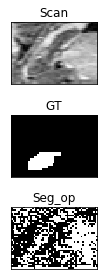

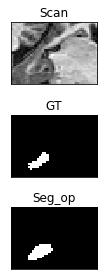

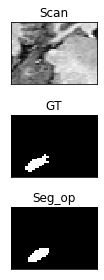

-------------- DONE --------------
---------- VALIDATING ------------


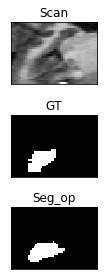

---------- EPOCH: 2 ----------
----------- TRAINING -------------


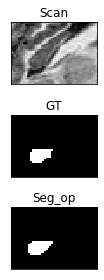

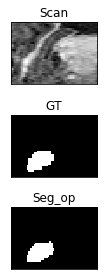

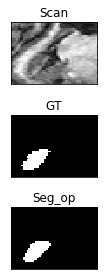

-------------- DONE --------------
---------- VALIDATING ------------


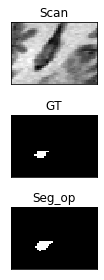

---------- EPOCH: 3 ----------
----------- TRAINING -------------


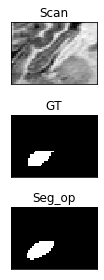

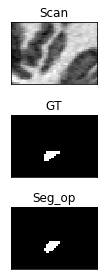

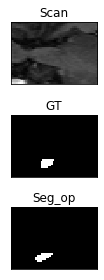

-------------- DONE --------------
---------- VALIDATING ------------


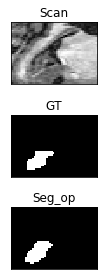

---------- EPOCH: 4 ----------
----------- TRAINING -------------


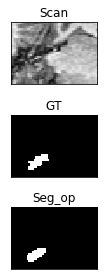

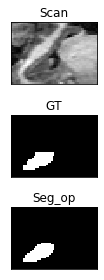

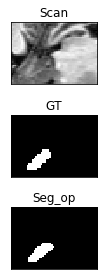

-------------- DONE --------------
---------- VALIDATING ------------


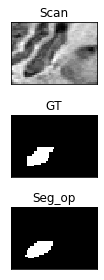

---------- EPOCH: 5 ----------
----------- TRAINING -------------


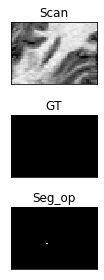

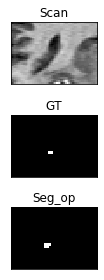

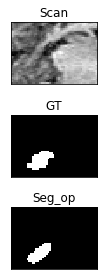

-------------- DONE --------------
---------- VALIDATING ------------


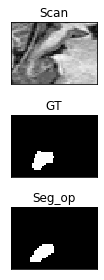

---------- EPOCH: 6 ----------
----------- TRAINING -------------


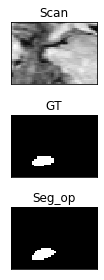

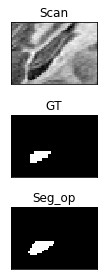

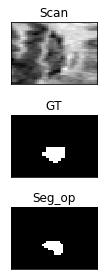

-------------- DONE --------------
---------- VALIDATING ------------


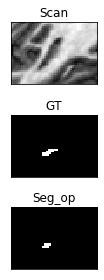

---------- EPOCH: 7 ----------
----------- TRAINING -------------


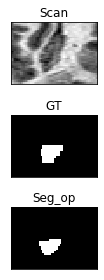

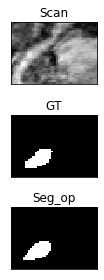

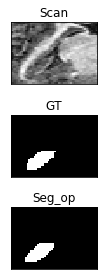

-------------- DONE --------------
---------- VALIDATING ------------


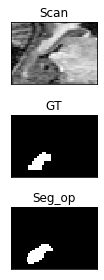

---------- EPOCH: 8 ----------
----------- TRAINING -------------


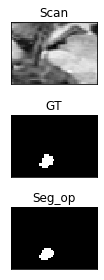

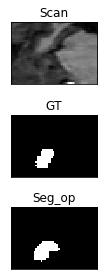

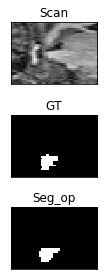

-------------- DONE --------------
---------- VALIDATING ------------


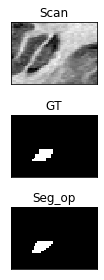

---------- EPOCH: 9 ----------
----------- TRAINING -------------


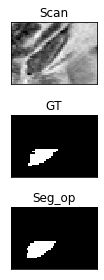

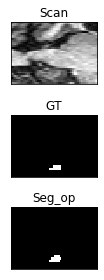

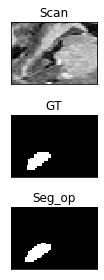

-------------- DONE --------------
---------- VALIDATING ------------


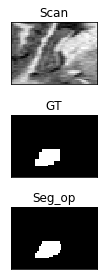

---------- EPOCH: 10 ----------
----------- TRAINING -------------


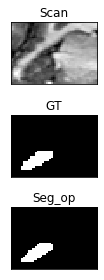

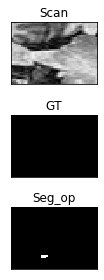

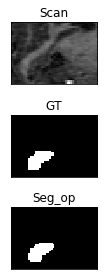

-------------- DONE --------------
---------- VALIDATING ------------


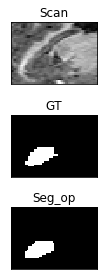

In [132]:
# with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
pbar_outer_outer = tqdm(total=epochs, desc = 'Epoch count')
pbar_outer = tqdm(total=epochs, desc = 'Epoch count')
for epoch in range(1, epochs+1):
    # print('Epoch: ', epoch)
    model4.train()
    avg_loss = 0.0
    avg_dscoeff = 0.0
    print('---------- EPOCH:', epoch, '----------')
    print('----------- TRAINING -------------')
    pbar_inner = tqdm(total = len(train_loader), desc = "train: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
    count = 0
    dscoeffs = []
    for i, batch in enumerate(train_loader):
        count+=1
        optimizer.zero_grad()
#         print(len(batch[0]))
        input_img = Variable(batch[1].type(torch.FloatTensor)).to(device)
        segs = Variable(batch[5][0].unsqueeze(0).type(torch.LongTensor)).to(device)
        outputs = model4(input_img)
        # print(torch.argmax(outputs, 1).shape)
        
        loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
        loss.backward()
        optimizer.step()
        dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, num_classes)
        dscoeffs.append(dscoeff)
        
        
        if (count%1000==1):
            fig = plt.figure()
            plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,1).set_title('Scan')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3,1,2).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,2).set_title('GT')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3,1,3).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,3).set_title('Seg_op')
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            plt.show()
        # losses1.append(loss.item())
        # dscoeffs.append(dscoeff)
        avg_loss += loss.item()
        avg_dscoeff += sum(dscoeff)/(batch_size*num_classes)
        pbar_inner.set_description("train: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/count,avg_dscoeff/count))
        pbar_inner.update(batch_size)
        pbar_outer.set_description("Epoch count: {}".format(epoch))
    # print(np.array(dscoeffs).shape)
    dscoeffs5.append(np.sum(np.array(dscoeffs), axis = 0)/len(train_loader))
    avg_losses5.append(avg_loss/len(train_loader))
    avg_dscoeffs5.append(avg_dscoeff/len(train_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("train: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/len(train_loader),avg_dscoeff/len(train_loader)))
#         pbar.set_postfix(**{'loss (batch)': loss.item(), 'DSC (batch)': dscoeff})
#         pbar.update(i)

    print('-------------- DONE --------------')
    # model0.eval()
    val_avg_loss = 0.0
    val_avg_dscoeff = 0.0
    print('---------- VALIDATING ------------')
    pbar_inner = tqdm(total = len(validation_loader), desc = "Val: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
    count = 0
    val_dscoeffs = []
    for i, batch in enumerate(validation_loader):
        with torch.no_grad():
            count+=1
            # optimizer.zero_grad()
    #         print(len(batch[0]))
            input_img = Variable(batch[1].type(torch.FloatTensor)).to(device)
            segs = Variable(batch[5][0].unsqueeze(0).type(torch.LongTensor)).to(device)
            outputs = model4(input_img)
            # print(outputs.shape)
            # print(torch.unique(torch.argmax(outputs, 1)))
            
            loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
            # loss.backward()
            # optimizer.step()
            dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, num_classes)
            
            val_dscoeffs.append(dscoeff)
            
            # print(torch.unique(outs))
    #             print("Epoch:", epoch, "| Iter:", i+1, "| loss:", round(loss.item(), 4), "| dsc:", round(dscoeff, 4))
            if (count%1000==1):
                fig = plt.figure()
                plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,1).set_title('Scan')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,2).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,2).set_title('GT')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,3).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,3).set_title('Seg_op')
                plt.xticks([])
                plt.yticks([])
                plt.tight_layout()
                plt.show()
            # val_losses.append(loss.item())
            # val_dscoeffs.append(dscoeff)
            val_avg_loss += loss.item()
            val_avg_dscoeff += sum(dscoeff)/(batch_size*num_classes)
            pbar_inner.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/count,val_avg_dscoeff/count))
            pbar_inner.update(batch_size)
            pbar_outer.set_description("Epoch count: {}".format(epoch))
    val_dscoeffs5.append(np.sum(np.array(val_dscoeffs), axis=0)/len(validation_loader))
    val_avg_dscoeffs5.append(val_avg_dscoeff/len(validation_loader))
    val_avg_losses5.append(val_avg_loss/len(validation_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/len(validation_loader),val_avg_dscoeff/len(validation_loader)))

In [133]:
print(dscoeffs5[-1])
print(val_dscoeffs5[-1])

[0.99581372 0.86888389]
[0.99469484 0.82637033]


In [282]:
filepath = 'saved_model_MO_left'+str(train_ratio)+'_SP.pt'
torch.save(model4.state_dict(), filepath)

In [126]:
model4 = UNet2D(2, 2).to(device)
model4.load_state_dict(torch.load(filepath, map_location=device))

RuntimeError: Error(s) in loading state_dict for UNet2D:
	size mismatch for conv_final.weight: copying a param with shape torch.Size([3, 32, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 32, 1, 1]).
	size mismatch for conv_final.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([2]).

In [134]:
epochs = 10
batch_size = 1
Lambda = 0.8
num_channels = 2
num_classes_1 = 2
num_classes_2 = 3

losses6 = []
dscoeffs6 = []
val_dscoeffs6 = []
avg_losses6 = []
val_avg_losses6 = []
avg_dscoeffs6 = []
val_avg_dscoeffs6 = []

model_enc = MO_Net_encoder(num_channels).to(device)
model_dec1 = MO_Net_decoder(num_classes_1).to(device)
model_dec2 = MO_Net_decoder(num_classes_2).to(device)
params1 = model4.state_dict()
params2 = model_enc.state_dict()
params3 = model_dec1.state_dict()
params4 = model_dec2.state_dict()

In [135]:
# PHASE 2
for item in params1:
    if item in params2:
        params2[item] = params1[item]
for item in params1:
    if item in params3:
        params3[item] = params1[item]
for item in params1:
    if item in params4:
        if (params4[item].shape == params1[item].shape):
            params4[item] = params1[item]
model_enc.load_state_dict(params2)
model_dec1.load_state_dict(params3)
model_dec2.load_state_dict(params4)
optimizer0 = optim.Adam(model_enc.parameters(), lr = 0.000003)
optimizer1 = optim.Adam(model_dec1.parameters(), lr = 0.000001)
optimizer2 = optim.Adam(model_dec2.parameters(), lr = 0.00001)

---------- EPOCH: 1 ----------
----------- TRAINING -------------


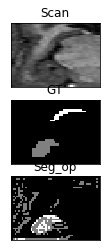

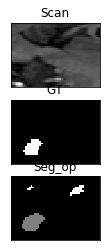

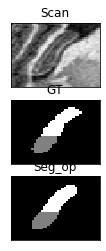

-------------- DONE --------------
---------- VALIDATING ------------


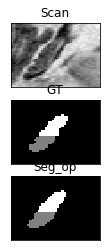

---------- EPOCH: 2 ----------
----------- TRAINING -------------


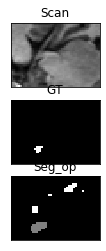

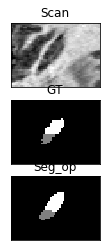

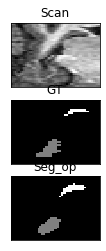

-------------- DONE --------------
---------- VALIDATING ------------


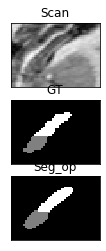

---------- EPOCH: 3 ----------
----------- TRAINING -------------


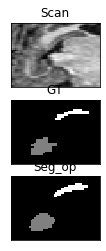

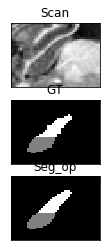

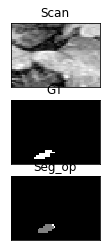

-------------- DONE --------------
---------- VALIDATING ------------


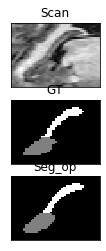

---------- EPOCH: 4 ----------
----------- TRAINING -------------


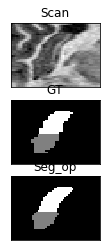

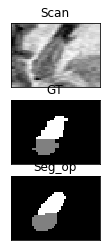

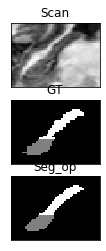

-------------- DONE --------------
---------- VALIDATING ------------


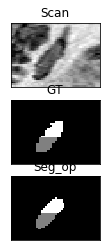

---------- EPOCH: 5 ----------
----------- TRAINING -------------


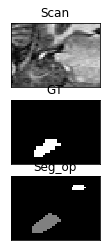

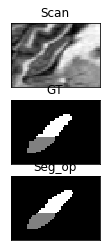

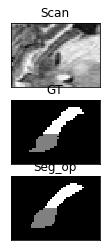

-------------- DONE --------------
---------- VALIDATING ------------


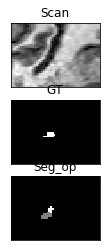

---------- EPOCH: 6 ----------
----------- TRAINING -------------


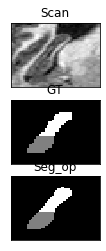

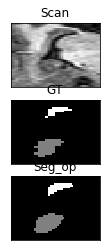

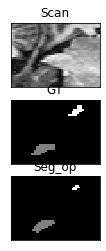

-------------- DONE --------------
---------- VALIDATING ------------


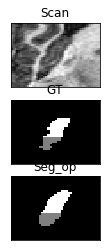

---------- EPOCH: 7 ----------
----------- TRAINING -------------


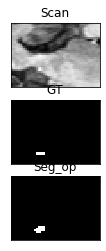

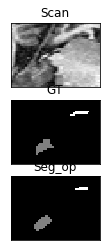

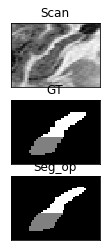

-------------- DONE --------------
---------- VALIDATING ------------


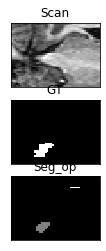

---------- EPOCH: 8 ----------
----------- TRAINING -------------


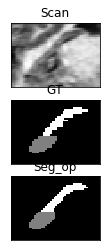

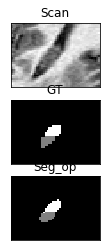

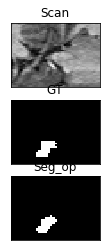

-------------- DONE --------------
---------- VALIDATING ------------


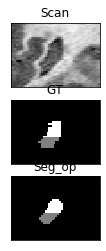

---------- EPOCH: 9 ----------
----------- TRAINING -------------


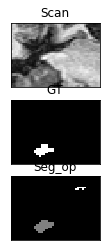

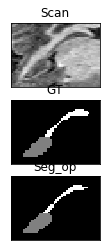

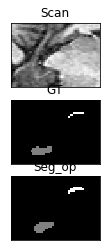

-------------- DONE --------------
---------- VALIDATING ------------


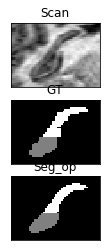

---------- EPOCH: 10 ----------
----------- TRAINING -------------


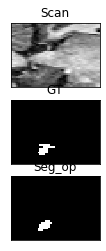

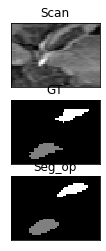

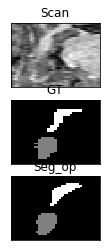

-------------- DONE --------------
---------- VALIDATING ------------


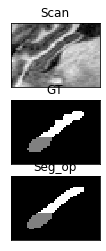

In [136]:
# with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
pbar_outer_outer = tqdm(total=epochs, desc = 'Epoch count')
pbar_outer = tqdm(total=epochs, desc = 'Epoch count')
for epoch in range(1, epochs+1):
    # print('Epoch: ', epoch)
    model_enc.train()
    model_dec1.train()
    model_dec2.train()
    avg_loss = 0.0
    avg_dscoeff = 0.0
    print('---------- EPOCH:', epoch, '----------')
    print('----------- TRAINING -------------')
    pbar_inner = tqdm(total = len(train_loader), desc = "train: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
    count = 0
    dscoeffs = []
    for i, batch in enumerate(train_loader):
        count+=1
        optimizer0.zero_grad()
        optimizer1.zero_grad()
        optimizer2.zero_grad()
#         print(len(batch[0]))
        input_img = Variable(batch[1].type(torch.FloatTensor)).to(device)
        segs = Variable(batch[5][0].unsqueeze(0).type(torch.LongTensor)).to(device)
        segs2 = Variable(batch[4][0].unsqueeze(0).type(torch.LongTensor)).to(device)
        encoder0, encoder1, encoder2, encoder3, center = model_enc(input_img)
        outputs1 = model_dec1(encoder0, encoder1, encoder2, encoder3, center)
        outputs2 = model_dec2(encoder0, encoder1, encoder2, encoder3, center)
        # print(torch.argmax(outputs, 1).shape)
        
        loss1 = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs1)
        loss2 = cross_ent_dice_loss(torch.squeeze(segs2, dim=1), outputs2)
        loss = ((1 - Lambda) * loss1) + (Lambda * loss2)
        loss.backward()

        optimizer0.step()
        optimizer1.step()
        optimizer2.step()

        dscoeff, outs, segs = dice_coeff_multiclass(segs2, outputs2, num_classes_2)
        dscoeffs.append(dscoeff)
#             print("Epoch:", epoch, "| Iter:", i+1, "| loss:", round(loss.item(), 4), "| dsc:", round(dscoeff, 4))
        if (count%1000==1):
            fig = plt.figure()
            plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,1).set_title('Scan')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3,1,2).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,2).set_title('GT')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3,1,3).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,3).set_title('Seg_op')
            plt.xticks([])
            plt.yticks([])
            plt.show()

        # losses.append(loss.item())
        # dscoeffs.append(dscoeff)
        avg_loss += loss.item()/batch_size
        avg_dscoeff += sum(dscoeff)/(batch_size*num_classes_2)
        pbar_inner.set_description("train: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/count,avg_dscoeff/count))
        pbar_inner.update(batch_size)
        pbar_outer.set_description("Epoch count: {}".format(epoch))
    dscoeffs6.append(np.sum(np.array(dscoeffs), axis=0)/len(train_loader))
    avg_losses6.append(avg_loss/len(train_loader))
    avg_dscoeffs6.append(avg_dscoeff/len(train_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("train: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/len(train_loader),avg_dscoeff/len(train_loader)))
#         pbar.set_postfix(**{'loss (batch)': loss.item(), 'DSC (batch)': dscoeff})
#         pbar.update(i)

    print('-------------- DONE --------------')
    # # model0.eval()
    val_avg_loss = 0.0
    val_avg_dscoeff = 0.0
    print('---------- VALIDATING ------------')
    pbar_inner = tqdm(total = len(validation_loader), desc = "Val: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
    count = 0
    val_dscoeffs = []
    for i, batch in enumerate(validation_loader):
        with torch.no_grad():
            count+=1
            # optimizer.zero_grad()
    #         print(len(batch[0]))
            input_img = Variable(batch[1].type(torch.FloatTensor)).to(device)
            segs = Variable(batch[5][0].unsqueeze(0).type(torch.LongTensor)).to(device)
            segs2 = Variable(batch[4][0].unsqueeze(0).type(torch.LongTensor)).to(device)
            encoder0, encoder1, encoder2, encoder3, center = model_enc(input_img)
            outputs1 = model_dec1(encoder0, encoder1, encoder2, encoder3, center)
            outputs2 = model_dec2(encoder0, encoder1, encoder2, encoder3, center)
            # print(outputs.shape)
            # print(torch.unique(torch.argmax(outputs, 1)))
            
            loss1 = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs1)
            loss2 = cross_ent_dice_loss(torch.squeeze(segs2, dim=1), outputs2)
            loss = ((1 - Lambda) * loss1) + (Lambda * loss2)
            # loss.backward()   
            # loss.backward()
            # optimizer.step()
            dscoeff, outs, segs = dice_coeff_multiclass(segs2, outputs2, num_classes_2)
        
#             print("Epoch:", epoch, "| Iter:", i+1, "| loss:", round(loss.item(), 4), "| dsc:", round(dscoeff, 4))
            if (count%1000==1):
                fig = plt.figure()
                plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,1).set_title('Scan')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,2).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,2).set_title('GT')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,3).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,3).set_title('Seg_op')
                plt.xticks([])
                plt.yticks([])
                plt.show()
            # val_losses.append(loss.item())
            val_dscoeffs.append(dscoeff)
            val_avg_loss += loss.item()/batch_size
            val_avg_dscoeff += sum(dscoeff)/(batch_size*num_classes_2)
            pbar_inner.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/count,val_avg_dscoeff/count))
            pbar_inner.update(batch_size)
            pbar_outer.set_description("Epoch count: {}".format(epoch))
    val_dscoeffs6.append(np.sum(np.array(val_dscoeffs), axis=0)/len(validation_loader))
    val_avg_losses6.append(val_avg_loss/len(validation_loader))
    val_avg_dscoeffs6.append(val_avg_dscoeff/len(validation_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/len(validation_loader),val_avg_dscoeff/len(validation_loader)))

In [137]:
print(dscoeffs6[-1])
print(val_dscoeffs6[-1])

[0.99216693 0.88303797 0.84067853]
[0.98996833 0.81887512 0.7730472 ]


In [297]:
filepath1 = 'saved_model_MOEnc_'+str(train_ratio)+'_SP.pt'
filepath2 = 'saved_model_MODec1_'+str(train_ratio)+'_SP.pt'
filepath3 = 'saved_model_MODec2_'+str(train_ratio)+'_SP.pt'
torch.save(model_enc.state_dict(), filepath1)
torch.save(model_dec1.state_dict(), filepath2)
torch.save(model_dec2.state_dict(), filepath3)

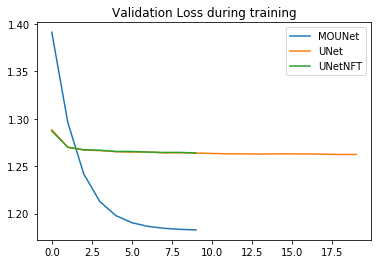

FileNotFoundError: [Errno 2] No such file or directory: 'Plots/right_left_valloss_1_SP.jpg'

In [57]:
fig=plt.figure()
plt.plot(val_avg_losses6, label = 'MOUNet')
plt.plot(val_avg_losses4, label = 'UNet')
plt.plot(val_avg_losses3, label = 'UNetNFT')
plt.legend()
plt.title('Validation Loss during training')
plt.show()
fig.savefig('Plots/right_left_valloss_'+str(train_ratio)+'_SP.jpg')

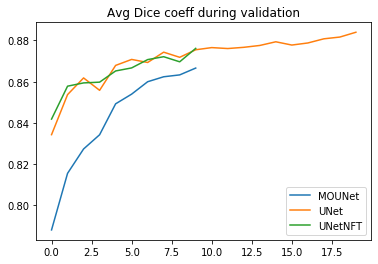

FileNotFoundError: [Errno 2] No such file or directory: 'Plots/right_left_valdice_1_SP.jpg'

In [58]:
fig=plt.figure()
plt.plot(val_avg_dscoeffs6, label = 'MOUNet')
plt.plot(val_avg_dscoeffs4, label = 'UNet')
plt.plot(val_avg_dscoeffs3, label = 'UNetNFT')
plt.title('Avg Dice coeff during validation')
plt.legend()
plt.show()
fig.savefig('Plots/right_left_valdice_'+str(train_ratio)+'_SP.jpg')

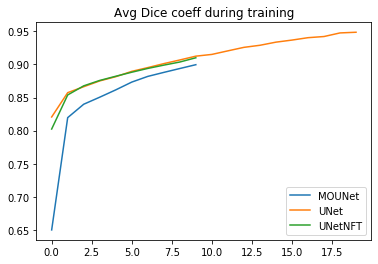

FileNotFoundError: [Errno 2] No such file or directory: 'Plots/right_left_traindice1_SP.jpg'

In [61]:
fig=plt.figure()
plt.plot(avg_dscoeffs6, label = 'MOUNet')
plt.plot(avg_dscoeffs4, label = 'UNet')
plt.plot(avg_dscoeffs3, label = 'UNetNFT')
plt.title('Avg Dice coeff during training')
plt.legend()
plt.show()
fig.savefig('Plots/right_left_traindice'+str(train_ratio)+'_SP.jpg')

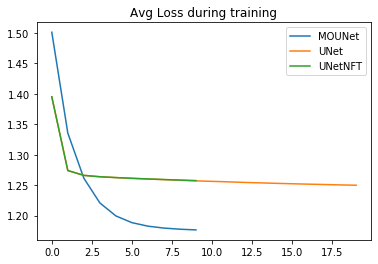

FileNotFoundError: [Errno 2] No such file or directory: 'Plots/right_left_trainloss1_SP.jpg'

In [60]:
fig=plt.figure()
plt.plot(avg_losses6, label = 'MOUNet')
plt.plot(avg_losses4, label = 'UNet')
plt.plot(avg_losses3, label = 'UNetNFT')
plt.title('Avg Loss during training')
plt.legend()
plt.show()
fig.savefig('Plots/right_left_trainloss'+str(train_ratio)+'_SP.jpg')